# Analyzing the PokeDex
Let's take a look at what Pokemon there are to work with

In [54]:
import torch
import cv2
import os
import matplotlib.pyplot as plt
torch.cuda.is_available()


True

In [55]:
def image_dataset_cleaner(dataset_path):
    """
    Removes images that cannot be read by cv2
    """
    import PIL as pil 
    for image in os.listdir(dataset_path):
        img = cv2.imread(os.path.join(dataset_path, image))
        if img is None:
            os.remove(os.path.join(dataset_path, image))
    return 

epoch

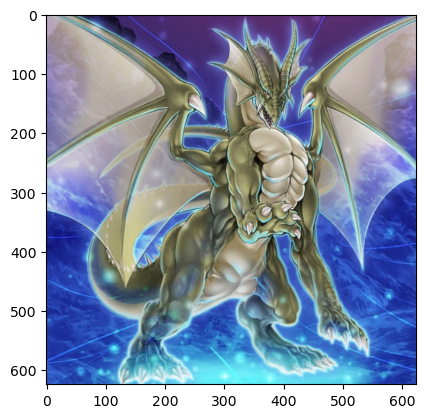

In [56]:
dataset_path = "training_magician/darkmagician"
image_name = "3078380.jpg"
img = cv2.imread(os.path.join(dataset_path, image_name))
# show the image
plt.imshow(img)

In [57]:
dataset_path = "training_magician/darkmagician"
print("The dataset before cleaning has " , len(os.listdir(dataset_path)))
image_dataset_cleaner(dataset_path)
print("The dataset after cleaning has " , len(os.listdir(dataset_path)))
IMAGE_COUNT = len(os.listdir(dataset_path))

The dataset before cleaning has  167
The dataset after cleaning has  167


### Testing my dataset, checking file integrity

In [58]:
image_name = "3078380.jpg"
os.path.join(dataset_path, image_name)

'training_magician/darkmagician/3078380.jpg'

In [59]:
from torch.utils.data import DataLoader, ConcatDataset
from torchvision.datasets import ImageFolder
import torchvision.transforms as T

In [60]:
IMAGE_DIR = "training_magician"
image_size = 64
batch_size = 8
normalization_stats = (0.5, 0.5, 0.5), (0.5, 0.5, 0.5) # Convert channels from [0, 1] to [-1, 1]

In [61]:
normal_dataset = ImageFolder(IMAGE_DIR, transform=T.Compose([
    T.Resize(image_size),
    T.CenterCrop(image_size),
    T.ToTensor(),
    T.Normalize(*normalization_stats)]))

# Augment the dataset with mirrored images
mirror_dataset = ImageFolder(IMAGE_DIR, transform=T.Compose([
    T.Resize(image_size),
    T.CenterCrop(image_size),
    T.RandomHorizontalFlip(p=1.0),
    T.ToTensor(),
    T.Normalize(*normalization_stats)]))

# Augment the dataset with color changes
color_jitter_dataset = ImageFolder(IMAGE_DIR, transform=T.Compose([
    T.Resize(image_size),
    T.CenterCrop(image_size),
    T.ColorJitter(0.5, 0.5, 0.5),
    T.ToTensor(),
    T.Normalize(*normalization_stats)]))

# Combine the datasets
dataset_list = [normal_dataset, mirror_dataset, color_jitter_dataset]

AUGMENTATION_RANGE = 10
dataset_list_full = []
for i in range(AUGMENTATION_RANGE):
    # normal_dataset
    dataset_list_full += dataset_list
    # dataset_list_full += [normal_dataset]

dataset = ConcatDataset(dataset_list)

dataloader = DataLoader(dataset, batch_size, shuffle=True, num_workers=4, pin_memory=False)

print("The estimated number of images is ", IMAGE_COUNT * AUGMENTATION_RANGE * 3)


The estimated number of images is  5010


Since these images have been normalized to [-1, 1],  we need to denormalize them in order to view them. Below is a denormalization function to do just that.

In [62]:
def denorm(image):
    return image * normalization_stats[1][0] + normalization_stats[0][0]

Now let's show a sample batch of real Pokemon images

In [63]:
import torch
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
%matplotlib inline

In [64]:
def show_images(images, nmax=64):
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(denorm(images.detach()[:nmax]), nrow=8).permute(1, 2, 0))
    
def show_batch(dataloader, nmax=64):
    for images, _ in dataloader:
        show_images(images, nmax)
        break

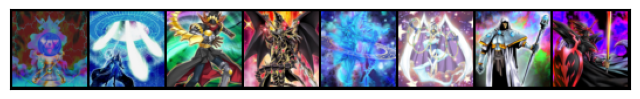

In [65]:
show_batch(dataloader)

Now that we know the visualization works, we can continue with making the GAN. First, we'll start with the discriminator

# Discriminator Models

Below I make a few possible discriminator models to try out

In [66]:
import torch.nn as nn

This is my first effort at making a discriminator for this dataset

In [67]:
disc_1 = nn.Sequential(
    # Input is 3 x 256 x 256
    nn.Conv2d(3, 16, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(16),
    nn.LeakyReLU(0.3, inplace=True),
    # Layer Output: 16 x 128 x 128
    
    nn.Conv2d(16, 32, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(32),
    nn.LeakyReLU(0.3, inplace=True),
    # Layer Output: 32 x 64 x 64
    
    nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.LeakyReLU(0.3, inplace=True),
    # Layer Output: 64 x 32 x 32
    
    nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.LeakyReLU(0.3, inplace=True),
    # Layer Output: 128 x 16 x 16
    
    nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.LeakyReLU(0.3, inplace=True),
    # Layer Output: 256 x 8 x 8
    
    nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(512),
    nn.LeakyReLU(0.3, inplace=True),
    # Layer Output: 512 x 4 x 4
    
    # With a 4x4, we can condense the channels into a 1 x 1 x 1 to produce output
    nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=0, bias=False),
    nn.Flatten(),
    nn.Sigmoid()
)

In [68]:
disc_2 = torch.hub.load('pytorch/vision:v0.6.0', 'resnet50', pretrained=True)
disc_2.fc.out_features = 1
disc_2

Using cache found in /home/codespace/.cache/torch/hub/pytorch_vision_v0.6.0


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [69]:
# Same as Discriminator 1, but with smaller kernel size
disc_3 = nn.Sequential(
    # Input is 3 x 256 x 256
    nn.Conv2d(3, 16, kernel_size=2, stride=2, padding=0, bias=False),
    nn.BatchNorm2d(16),
    nn.LeakyReLU(0.3, inplace=True),
    # Layer Output: 16 x 128 x 128
    
    nn.Conv2d(16, 32, kernel_size=2, stride=2, padding=0, bias=False),
    nn.BatchNorm2d(32),
    nn.LeakyReLU(0.3, inplace=True),
    # Layer Output: 32 x 64 x 64
    
    nn.Conv2d(32, 64, kernel_size=2, stride=2, padding=0, bias=False),
    nn.BatchNorm2d(64),
    nn.LeakyReLU(0.3, inplace=True),
    # Layer Output: 64 x 32 x 32
    
    nn.Conv2d(64, 128, kernel_size=2, stride=2, padding=0, bias=False),
    nn.BatchNorm2d(128),
    nn.LeakyReLU(0.3, inplace=True),
    # Layer Output: 128 x 16 x 16
    
    nn.Conv2d(128, 256, kernel_size=2, stride=2, padding=0, bias=False),
    nn.BatchNorm2d(256),
    nn.LeakyReLU(0.3, inplace=True),
    # Layer Output: 256 x 8 x 8
    
    nn.Conv2d(256, 512, kernel_size=2, stride=2, padding=0, bias=False),
    nn.BatchNorm2d(512),
    nn.LeakyReLU(0.3, inplace=True),
    # Layer Output: 512 x 4 x 4
    
    # Additional layer to make it 2x2
    nn.Conv2d(512, 1024, kernel_size=2, stride=2, padding=0, bias=False),
    nn.BatchNorm2d(1024),
    nn.LeakyReLU(0.3, inplace=True),
    # Layer Output: 512 x 2 x 2
    
    # With a 2x2, we can condense the channels into a 1 x 1 x 1 to produce output
    nn.Conv2d(1024, 1, kernel_size=2, stride=1, padding=0, bias=False),
    nn.Flatten(),
    nn.Sigmoid()
)

In [70]:
disc_5 = nn.Sequential(
    # Input is 3 x 256 x 256
    nn.Conv2d(3, 32, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(32),
    nn.LeakyReLU(0.15, inplace=True),
    # Layer Output: 64 x 128 x 128
    
    nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.LeakyReLU(0.15, inplace=True),
    # Layer Output: 128 x 64 x 64
    
    nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.LeakyReLU(0.15, inplace=True),
    # Layer Output: 256 x 32 x 32
    
    nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.LeakyReLU(0.15, inplace=True),
    # Layer Output: 256 x 16 x 16
    
    nn.Conv2d(256, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.LeakyReLU(0.15, inplace=True),
    # Layer Output: 256 x 8 x 8
    
    nn.Conv2d(256, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.LeakyReLU(0.15, inplace=True),
    # Layer Output: 256 x 4 x 4
    
    # With a 4x4, we can condense the channels into a 1 x 1 x 1 to produce output
    nn.Conv2d(256, 1, kernel_size=4, stride=1, padding=0, bias=False),
    nn.Flatten(),
    nn.Sigmoid()
)

In [71]:
disc_64_1 = nn.Sequential(
    # Input is 3 x 64 x 64
    nn.Conv2d(3, 32, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(32),
    nn.LeakyReLU(0.2, inplace=True),
    # Layer Output: 32 x 32 x 32
    
    nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.LeakyReLU(0.2, inplace=True),
    # Layer Output: 64 x 16 x 16
    
    nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.LeakyReLU(0.2, inplace=True),
    # Layer Output: 128 x 8 x 8
    
    nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.LeakyReLU(0.2, inplace=True),
    # Layer Output: 256 x 4 x 4
    
    # With a 4x4, we can condense the channels into a 1 x 1 x 1 to produce output
    nn.Conv2d(256, 1, kernel_size=4, stride=1, padding=0, bias=False),
    nn.Flatten(),
    nn.Sigmoid()
)

In [72]:
disc_64_2 = nn.Sequential(
    # Input is 3 x 64 x 64
    nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.LeakyReLU(0.2, inplace=True),
    # Layer Output: 64 x 32 x 32
    
    nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.LeakyReLU(0.2, inplace=True),
    # Layer Output: 128 x 16 x 16
    
    nn.Conv2d(128, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.LeakyReLU(0.2, inplace=True),
    # Layer Output: 128 x 8 x 8
    
    nn.Conv2d(128, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.LeakyReLU(0.2, inplace=True),
    # Layer Output: 128 x 4 x 4
    
    # With a 4x4, we can condense the channels into a 1 x 1 x 1 to produce output
    nn.Conv2d(128, 1, kernel_size=4, stride=1, padding=0, bias=False),
    nn.Flatten(),
    nn.Sigmoid()
)

# Generator Models

Below is a list of some possible generator models to try. These models are inverse operations of the discriminators.

Here's the first generator:

In [73]:
seed_size = 16

In [74]:
gen_1 = nn.Sequential(
    # Input seed_size x 1 x 1
    nn.ConvTranspose2d(seed_size, 512, kernel_size=4, padding=0, stride=1, bias=False),
    nn.BatchNorm2d(512),
    nn.ReLU(True),
    # Layer output: 512 x 4 x 4
    
    nn.ConvTranspose2d(512, 256, kernel_size=4, padding=1, stride=2, bias=False),
    nn.BatchNorm2d(256),
    nn.ReLU(True),
    # Layer output: 256 x 8 x 8
    
    nn.ConvTranspose2d(256, 128, kernel_size=4, padding=1, stride=2, bias=False),
    nn.BatchNorm2d(128),
    nn.ReLU(True),
    # Layer output: 128 x 16 x 16
    
    nn.ConvTranspose2d(128, 64, kernel_size=4, padding=1, stride=2, bias=False),
    nn.BatchNorm2d(64),
    nn.ReLU(True),
    # Layer output: 64 x 32 x 32
    
    nn.ConvTranspose2d(64, 32, kernel_size=4, padding=1, stride=2, bias=False),
    nn.BatchNorm2d(32),
    nn.ReLU(True),
    # Layer output: 32 x 64 x 64
    
    nn.ConvTranspose2d(32, 16, kernel_size=4, padding=1, stride=2, bias=False),
    nn.BatchNorm2d(16),
    nn.ReLU(True),
    # Layer output: 16 x 128 x 128
    
    nn.ConvTranspose2d(16, 3, kernel_size=4, padding=1, stride=2, bias=False),
    nn.Tanh()
    # Output: 3 x 256 x 256
)

In [75]:
# Generator matching Discriminator 3
gen_3 = nn.Sequential(
    # Input seed_size x 1 x 1
    nn.ConvTranspose2d(seed_size, 1024, kernel_size=2, padding=0, stride=1, bias=False),
    nn.BatchNorm2d(1024),
    nn.ReLU(True),
    # Layer output: 1024 x 2 x 2
    
    nn.ConvTranspose2d(1024, 512, kernel_size=2, padding=0, stride=2, bias=False),
    nn.BatchNorm2d(512),
    nn.ReLU(True),
    # Layer output: 512 x 4 x 4
    
    nn.ConvTranspose2d(512, 256, kernel_size=2, padding=0, stride=2, bias=False),
    nn.BatchNorm2d(256),
    nn.ReLU(True),
    # Layer output: 256 x 8 x 8
    
    nn.ConvTranspose2d(256, 128, kernel_size=2, padding=0, stride=2, bias=False),
    nn.BatchNorm2d(128),
    nn.ReLU(True),
    # Layer output: 128 x 16 x 16
    
    nn.ConvTranspose2d(128, 64, kernel_size=2, padding=0, stride=2, bias=False),
    nn.BatchNorm2d(64),
    nn.ReLU(True),
    # Layer output: 64 x 32 x 32
    
    nn.ConvTranspose2d(64, 32, kernel_size=2, padding=0, stride=2, bias=False),
    nn.BatchNorm2d(32),
    nn.ReLU(True),
    # Layer output: 32 x 64 x 64
    
    nn.ConvTranspose2d(32, 16, kernel_size=2, padding=0, stride=2, bias=False),
    nn.BatchNorm2d(16),
    nn.ReLU(True),
    # Layer output: 16 x 128 x 128
    
    nn.ConvTranspose2d(16, 3, kernel_size=2, padding=0, stride=2, bias=False),
    nn.Tanh()
    # Output: 3 x 256 x 256
)

In [76]:
# Generator with lots of upsampling weirdness
gen_4 = nn.Sequential(
    # Input seed_size x 1 x 1
    nn.ConvTranspose2d(seed_size, 1024, kernel_size=2, padding=0, stride=1, bias=False),
    nn.BatchNorm2d(1024),
    nn.ReLU(True),
    # Layer output: 1024 x 2 x 2
    
    nn.ConvTranspose2d(1024, 512, kernel_size=2, padding=0, stride=2, bias=False),
    nn.BatchNorm2d(512),
    nn.ReLU(True),
    # Layer output: 512 x 4 x 4
    
    nn.ConvTranspose2d(512, 256, kernel_size=2, padding=0, stride=2, bias=False),
    nn.BatchNorm2d(256),
    nn.ReLU(True),
    # Layer output: 256 x 8 x 8
    
    nn.ConvTranspose2d(256, 128, kernel_size=3, padding=1, stride=9, bias=False),
    nn.BatchNorm2d(128),
    nn.ReLU(True),
    # Layer output: 128 x 64 x 64
    
    nn.ConvTranspose2d(128, 3, kernel_size=4, padding=0, stride=4, bias=False),
    nn.Tanh()
    # Output: 3 x 256 x 256
)

In [77]:
gen_5 = nn.Sequential(
    # Input seed_size x 1 x 1
    nn.ConvTranspose2d(seed_size, 256, kernel_size=4, padding=0, stride=1, bias=False),
    nn.BatchNorm2d(256),
    nn.ReLU(True),
    # Layer output: 256 x 4 x 4
    
    nn.ConvTranspose2d(256, 256, kernel_size=4, padding=1, stride=2, bias=False),
    nn.BatchNorm2d(256),
    nn.ReLU(True),
    # Layer output: 256 x 8 x 8
    
    nn.ConvTranspose2d(256, 256, kernel_size=4, padding=1, stride=2, bias=False),
    nn.BatchNorm2d(256),
    nn.ReLU(True),
    # Layer output: 256 x 16 x 16
    
    nn.ConvTranspose2d(256, 128, kernel_size=4, padding=1, stride=2, bias=False),
    nn.BatchNorm2d(128),
    nn.ReLU(True),
    # Layer output: 128 x 32 x 32
    
    nn.ConvTranspose2d(128, 64, kernel_size=4, padding=1, stride=2, bias=False),
    nn.BatchNorm2d(64),
    nn.ReLU(True),
    # Layer output: 128 x 64 x 64
    
    nn.ConvTranspose2d(64, 32, kernel_size=4, padding=1, stride=2, bias=False),
    nn.BatchNorm2d(32),
    nn.ReLU(True),
    # Layer output: 64 x 128 x 128
    
    nn.ConvTranspose2d(32, 3, kernel_size=4, padding=1, stride=2, bias=False),
    nn.Tanh()
    # Output: 3 x 256 x 256
)

In [78]:
gen_64_1 = nn.Sequential(
    # Input seed_size x 1 x 1
    nn.ConvTranspose2d(seed_size, 256, kernel_size=4, padding=0, stride=1, bias=False),
    nn.BatchNorm2d(256),
    nn.ReLU(True),
    # Layer output: 256 x 4 x 4
    
    nn.ConvTranspose2d(256, 128, kernel_size=4, padding=1, stride=2, bias=False),
    nn.BatchNorm2d(128),
    nn.ReLU(True),
    # Layer output: 128 x 8 x 8
    
    nn.ConvTranspose2d(128, 64, kernel_size=4, padding=1, stride=2, bias=False),
    nn.BatchNorm2d(64),
    nn.ReLU(True),
    # Layer output: 64 x 16 x 16
    
    nn.ConvTranspose2d(64, 32, kernel_size=4, padding=1, stride=2, bias=False),
    nn.BatchNorm2d(32),
    nn.ReLU(True),
    # Layer output: 32 x 32 x 32
    
    nn.ConvTranspose2d(32, 3, kernel_size=4, padding=1, stride=2, bias=False),
    nn.Tanh()
    # Output: 3 x 64 x 64
)

In [79]:
gen_64_2 = nn.Sequential(
    # Input seed_size x 1 x 1
    nn.ConvTranspose2d(seed_size, 128, kernel_size=4, padding=0, stride=1, bias=False),
    nn.BatchNorm2d(128),
    nn.ReLU(True),
    # Layer output: 256 x 4 x 4
    
    nn.ConvTranspose2d(128, 128, kernel_size=4, padding=1, stride=2, bias=False),
    nn.BatchNorm2d(128),
    nn.ReLU(True),
    # Layer output: 128 x 8 x 8
    
    nn.ConvTranspose2d(128, 128, kernel_size=4, padding=1, stride=2, bias=False),
    nn.BatchNorm2d(128),
    nn.ReLU(True),
    # Layer output: 64 x 16 x 16
    
    nn.ConvTranspose2d(128, 64, kernel_size=4, padding=1, stride=2, bias=False),
    nn.BatchNorm2d(64),
    nn.ReLU(True),
    # Layer output: 32 x 32 x 32
    
    nn.ConvTranspose2d(64, 3, kernel_size=4, padding=1, stride=2, bias=False),
    nn.Tanh()
    # Output: 3 x 64 x 64
)

# Model Testing

This is to make sure everything is the correct size

In [80]:
test_model_size = False

if test_model_size:
    # Make some latent tensors to seed the generator
    seed_batch = torch.randn(batch_size, seed_size, 1, 1, device=device)

    # Get some fake pokemon
    generator=gen_64_1
    to_device(generator, device)
    fake_pokemon = generator(seed_batch)
    print(fake_pokemon.size())

# GPU Setup
We should train this on a GPU, so I'll set that up right now

In [81]:
def get_training_device():
    # Use the GPU if possible
    if torch.cuda.is_available():
        return torch.device('cuda')
    # Otherwise use the CPU :-(
    return torch.device('cpu')

def to_device(data, device):
    # This moves the tensors to the device (GPU, CPU)
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dataloader, device):
        self.dataloader = dataloader
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dataloader: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dataloader)

In [82]:
device = get_training_device()
device

device(type='cuda')

If the above output doesn't say something about 'cuda', then make sure the notebook is set up to run on the GPU accelerator.  

Now, we use the device dataloader class to send data to our chosen device:

In [83]:
# Using the dataloader from the top of the notebook, and the selected device
# create a device data loader
dev_dataloader = DeviceDataLoader(dataloader, device)

# **Training Functions**

## Discriminator

In [84]:
def train_discriminator(real_pokemon, disc_optimizer):
    # Reset the gradients for the optimizer
    disc_optimizer.zero_grad()
    
    # Train on the real images
    real_predictions = discriminator(real_pokemon)
    # real_targets = torch.zeros(real_pokemon.size(0), 1, device=device) # All of these are real, so the target is 0.
    real_targets = torch.rand(real_pokemon.size(0), 1, device=device) * (0.1 - 0) + 0 # Add some noisy labels to make the discriminator think harder.
    real_loss = F.binary_cross_entropy(real_predictions, real_targets) # Can do binary loss function because it is a binary classifier
    real_score = torch.mean(real_predictions).item() # How well does the discriminator classify the real pokemon? (Higher score is better for the discriminator)
    
    # Make some latent tensors to seed the generator
    latent_batch = torch.randn(batch_size, seed_size, 1, 1, device=device)
    
    # Get some fake pokemon
    fake_pokemon = generator(latent_batch)
    
    # Train on the generator's current efforts to trick the discriminator
    gen_predictions = discriminator(fake_pokemon)
    # gen_targets = torch.ones(fake_pokemon.size(0), 1, device=device)
    gen_targets = torch.rand(fake_pokemon.size(0), 1, device=device) * (1 - 0.9) + 0.9 # Add some noisy labels to make the discriminator think harder.
    gen_loss = F.binary_cross_entropy(gen_predictions, gen_targets)
    gen_score = torch.mean(gen_predictions).item() # How well did the discriminator classify the fake pokemon? (Lower score is better for the discriminator)
    
    # Update the discriminator weights
    total_loss = real_loss + gen_loss
    total_loss.backward()
    disc_optimizer.step()
    return total_loss.item(), real_score, gen_score

## Generator

In [85]:
def train_generator(gen_optimizer):
    # Clear the generator gradients
    gen_optimizer.zero_grad()
    
    # Generate some fake pokemon
    latent_batch = torch.randn(batch_size, seed_size, 1, 1, device=device)
    fake_pokemon = generator(latent_batch)
    
    # Test against the discriminator
    disc_predictions = discriminator(fake_pokemon)
    targets = torch.zeros(fake_pokemon.size(0), 1, device=device) # We want the discriminator to think these images are real.
    loss = F.binary_cross_entropy(disc_predictions, targets) # How well did the generator do? (How much did the discriminator believe the generator?)
    
    # Update the generator based on how well it fooled the discriminator
    loss.backward()
    gen_optimizer.step()
    
    # Return generator loss
    return loss.item()

## Results Viewer
We want to be able to see the results as we generate pokemon

In [86]:
import os
from torchvision.utils import save_image

RESULTS_DIR = 'results'
os.makedirs(RESULTS_DIR, exist_ok=True)

In [87]:
def save_results(index, latent_batch, show=True):
    # Generate fake pokemon
    fake_pokemon = generator(latent_batch)
    
    # Make the filename for the output
    fake_file = "result-image-{0:0=4d}.png".format(index)
    
    # Save the image
    save_image(denorm(fake_pokemon), os.path.join(RESULTS_DIR, fake_file), nrow=8)
    print("Result Saved!")
    
    if show:
        fig, ax = plt.subplots(figsize=(8, 8))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(fake_pokemon.cpu().detach(), nrow=8).permute(1, 2, 0))

# **Full Training**

In [88]:
from tqdm.notebook import tqdm
import torch.nn.functional as F

# Static generation seed batch
fixed_latent_batch = torch.randn(64, seed_size, 1, 1, device=device)

def train(epochs, learning_rate, start_idx=1):
    # Empty the GPU cache to save some memory
    torch.cuda.empty_cache()
    
    # Track losses and scores
    disc_losses = []
    disc_scores = []
    gen_losses = []
    gen_scores = []
    
    # Create the optimizers
    disc_optimizer = torch.optim.Adam(discriminator.parameters(), lr=learning_rate, betas=(0.5, 0.9))
    gen_optimizer = torch.optim.Adam(generator.parameters(), lr=learning_rate, betas=(0.5, 0.9))
    
    # Run the loop
    for epoch in range(epochs):
        # Go through each image
        for real_img, _ in tqdm(dev_dataloader):
            # Train the discriminator
            disc_loss, real_score, gen_score = train_discriminator(real_img, disc_optimizer)

            # Train the generator
            gen_loss = train_generator(gen_optimizer)
        
        # Collect results
        disc_losses.append(disc_loss)
        disc_scores.append(real_score)
        gen_losses.append(gen_loss)
        gen_scores.append(gen_score)
        
        # Print the losses and scores
        print("Epoch [{}/{}], gen_loss: {:.4f}, disc_loss: {:.4f}, real_score: {:.4f}, gen_score: {:.4f}".format(
            epoch+start_idx, epochs, gen_loss, disc_loss, real_score, gen_score))
        
        # Save the images and show the progress
        save_results(epoch + start_idx, fixed_latent_batch, show=False)
    
    # Return stats
    return disc_losses, disc_scores, gen_losses, gen_scores

# GPU Clean-up
Sometimes the Kaggle GPU runs out of memory. This block frees up the GPU and resends the device dataloader to the GPU

In [89]:
device = get_training_device()
device

device(type='cuda')

In [90]:
def debug_memory():
    import collections, gc, resource, torch
    print('maxrss = {}'.format(
        resource.getrusage(resource.RUSAGE_SELF).ru_maxrss))
    tensors = collections.Counter((str(o.device), o.dtype, tuple(o.shape))
                                  for o in gc.get_objects()
                                  if torch.is_tensor(o))
    for line in tensors.items():
        print('{}\t{}'.format(*line))

In [91]:
mem_debug = False
if mem_debug:
    debug_memory()

In [92]:
# Clean up everything
cleanup = False
if cleanup:
    import gc
    del dev_dataloader
    del discriminator
    del generator
    dev_dataloader = None
    discriminator = None
    generator = None
    gc.collect()
    torch.cuda.empty_cache()

In [93]:
# Re-initialize the device dataloader
dev_dataloader = DeviceDataLoader(dataloader, device)

# Selecting Models
Here, I select the models I want to send to the GPU

In [94]:
# Discriminators
# discriminator = disc_1
# discriminator = disc_2
# discriminator = disc_3
# discriminator = disc_5

# 64 x 64 Discriminators
# discriminator = disc_64_1
discriminator = disc_64_2

# Send to device
discriminator = to_device(discriminator, device)

In [95]:
# Generators
# generator = gen_1
# generator = gen_3
# generator = gen_5

# 64 x 64 Generators
# generator = gen_64_1
generator = gen_64_2

# Send to device
generator = to_device(generator, device)

# Training Time
Here I'll edit hyperparameters and train the GAN

In [96]:
# learning_rate = 0.0025 # worked fairly well for disc/gen_64_1
learning_rate = 0.00275
epochs = 1000

In [97]:
history = train(epochs, learning_rate)

  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [1/1000], gen_loss: 3.1027, disc_loss: 0.4737, real_score: 0.0841, gen_score: 0.8781
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [2/1000], gen_loss: 3.3074, disc_loss: 2.2302, real_score: 0.0199, gen_score: 0.1941
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [3/1000], gen_loss: 3.8449, disc_loss: 1.8015, real_score: 0.6801, gen_score: 0.9929
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [4/1000], gen_loss: 2.1933, disc_loss: 0.4841, real_score: 0.0849, gen_score: 0.8854
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [5/1000], gen_loss: 5.8443, disc_loss: 1.9071, real_score: 0.0482, gen_score: 0.1904
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [6/1000], gen_loss: 3.1530, disc_loss: 0.8454, real_score: 0.3623, gen_score: 0.8231
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [7/1000], gen_loss: 2.3654, disc_loss: 0.4470, real_score: 0.0307, gen_score: 0.8936
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [8/1000], gen_loss: 1.1703, disc_loss: 1.2035, real_score: 0.6056, gen_score: 0.8867
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [9/1000], gen_loss: 2.8236, disc_loss: 0.4272, real_score: 0.0214, gen_score: 0.8451
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [10/1000], gen_loss: 4.2964, disc_loss: 0.5194, real_score: 0.0547, gen_score: 0.8730
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [11/1000], gen_loss: 2.5608, disc_loss: 0.4818, real_score: 0.0137, gen_score: 0.9191
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [12/1000], gen_loss: 4.4861, disc_loss: 0.5219, real_score: 0.1457, gen_score: 0.9488
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [13/1000], gen_loss: 4.4920, disc_loss: 0.5794, real_score: 0.0260, gen_score: 0.8952
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [14/1000], gen_loss: 3.1108, disc_loss: 0.4188, real_score: 0.0655, gen_score: 0.8744
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [15/1000], gen_loss: 2.6034, disc_loss: 0.9850, real_score: 0.4462, gen_score: 0.9561
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [16/1000], gen_loss: 5.2974, disc_loss: 0.6104, real_score: 0.0237, gen_score: 0.8531
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [17/1000], gen_loss: 4.0866, disc_loss: 0.8050, real_score: 0.2611, gen_score: 0.7220
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [18/1000], gen_loss: 5.9954, disc_loss: 0.4083, real_score: 0.0786, gen_score: 0.9296
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [19/1000], gen_loss: 2.9802, disc_loss: 0.9024, real_score: 0.3711, gen_score: 0.7853
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [20/1000], gen_loss: 3.0043, disc_loss: 0.5292, real_score: 0.1078, gen_score: 0.8066
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [21/1000], gen_loss: 2.9804, disc_loss: 0.7552, real_score: 0.3075, gen_score: 0.8394
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [22/1000], gen_loss: 4.7665, disc_loss: 0.6768, real_score: 0.0136, gen_score: 0.6951
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [23/1000], gen_loss: 6.6214, disc_loss: 1.1573, real_score: 0.1493, gen_score: 0.5248
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [24/1000], gen_loss: 6.0086, disc_loss: 1.2036, real_score: 0.0434, gen_score: 0.5228
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [25/1000], gen_loss: 3.6370, disc_loss: 0.5622, real_score: 0.0859, gen_score: 0.7722
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [26/1000], gen_loss: 3.1974, disc_loss: 0.6689, real_score: 0.0298, gen_score: 0.7664
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [27/1000], gen_loss: 5.0792, disc_loss: 0.8138, real_score: 0.0158, gen_score: 0.6052
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [28/1000], gen_loss: 5.4886, disc_loss: 0.9506, real_score: 0.0208, gen_score: 0.4967
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [29/1000], gen_loss: 5.0751, disc_loss: 0.8083, real_score: 0.0725, gen_score: 0.6570
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [30/1000], gen_loss: 4.1465, disc_loss: 0.5819, real_score: 0.0668, gen_score: 0.7869
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [31/1000], gen_loss: 2.5158, disc_loss: 0.8184, real_score: 0.4120, gen_score: 0.9637
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [32/1000], gen_loss: 4.1007, disc_loss: 0.5076, real_score: 0.0847, gen_score: 0.8594
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [33/1000], gen_loss: 4.0712, disc_loss: 1.0698, real_score: 0.2807, gen_score: 0.5812
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [34/1000], gen_loss: 3.8074, disc_loss: 0.5048, real_score: 0.1573, gen_score: 0.9002
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [35/1000], gen_loss: 2.7579, disc_loss: 0.7253, real_score: 0.0331, gen_score: 0.6749
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [36/1000], gen_loss: 1.7698, disc_loss: 1.9827, real_score: 0.4334, gen_score: 0.9413
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [37/1000], gen_loss: 5.4532, disc_loss: 0.7775, real_score: 0.0273, gen_score: 0.6758
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [38/1000], gen_loss: 2.6734, disc_loss: 0.5762, real_score: 0.0734, gen_score: 0.8535
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [39/1000], gen_loss: 4.2145, disc_loss: 0.6966, real_score: 0.2810, gen_score: 0.8329
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [40/1000], gen_loss: 3.0352, disc_loss: 2.2024, real_score: 0.8066, gen_score: 0.9505
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [41/1000], gen_loss: 4.3159, disc_loss: 1.1131, real_score: 0.0211, gen_score: 0.4447
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [42/1000], gen_loss: 3.6552, disc_loss: 0.7745, real_score: 0.3206, gen_score: 0.9918
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [43/1000], gen_loss: 4.1258, disc_loss: 0.7591, real_score: 0.2920, gen_score: 0.8669
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [44/1000], gen_loss: 2.9442, disc_loss: 1.1096, real_score: 0.0771, gen_score: 0.5553
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [45/1000], gen_loss: 3.9404, disc_loss: 0.6816, real_score: 0.2367, gen_score: 0.9316
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [46/1000], gen_loss: 4.7030, disc_loss: 0.5148, real_score: 0.2248, gen_score: 0.9022
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [47/1000], gen_loss: 1.6422, disc_loss: 1.1460, real_score: 0.4909, gen_score: 0.7407
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [48/1000], gen_loss: 2.6931, disc_loss: 1.4274, real_score: 0.5579, gen_score: 0.5843
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [49/1000], gen_loss: 3.2760, disc_loss: 1.2040, real_score: 0.5389, gen_score: 0.9331
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [50/1000], gen_loss: 5.0165, disc_loss: 0.9565, real_score: 0.1637, gen_score: 0.6345
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [51/1000], gen_loss: 1.8914, disc_loss: 0.5792, real_score: 0.1332, gen_score: 0.9300
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [52/1000], gen_loss: 2.6371, disc_loss: 0.5487, real_score: 0.0157, gen_score: 0.9372
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [53/1000], gen_loss: 5.1344, disc_loss: 0.5579, real_score: 0.1617, gen_score: 0.8852
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [54/1000], gen_loss: 5.7461, disc_loss: 0.5775, real_score: 0.1282, gen_score: 0.8661
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [55/1000], gen_loss: 4.9143, disc_loss: 0.7654, real_score: 0.3182, gen_score: 0.8536
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [56/1000], gen_loss: 2.6629, disc_loss: 0.5989, real_score: 0.1360, gen_score: 0.8438
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [57/1000], gen_loss: 4.9430, disc_loss: 1.5220, real_score: 0.0386, gen_score: 0.2959
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [58/1000], gen_loss: 4.0348, disc_loss: 0.6585, real_score: 0.0950, gen_score: 0.7718
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [59/1000], gen_loss: 4.5741, disc_loss: 0.4535, real_score: 0.1111, gen_score: 0.8585
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [60/1000], gen_loss: 5.5474, disc_loss: 0.6287, real_score: 0.0735, gen_score: 0.8363
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [61/1000], gen_loss: 4.2077, disc_loss: 0.5485, real_score: 0.0199, gen_score: 0.7925
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [62/1000], gen_loss: 4.4018, disc_loss: 0.5335, real_score: 0.0872, gen_score: 0.8966
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [63/1000], gen_loss: 3.6774, disc_loss: 0.6375, real_score: 0.0317, gen_score: 0.7832
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [64/1000], gen_loss: 3.9747, disc_loss: 0.5455, real_score: 0.0274, gen_score: 0.8891
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [65/1000], gen_loss: 4.7811, disc_loss: 0.5740, real_score: 0.0227, gen_score: 0.7563
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [66/1000], gen_loss: 4.7658, disc_loss: 1.1183, real_score: 0.0609, gen_score: 0.4811
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [67/1000], gen_loss: 4.4185, disc_loss: 0.5552, real_score: 0.1150, gen_score: 0.8641
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [68/1000], gen_loss: 3.0500, disc_loss: 0.4474, real_score: 0.0357, gen_score: 0.9037
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [69/1000], gen_loss: 5.3046, disc_loss: 0.4474, real_score: 0.0664, gen_score: 0.9227
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [70/1000], gen_loss: 4.4629, disc_loss: 0.4587, real_score: 0.0202, gen_score: 0.9503
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [71/1000], gen_loss: 3.8113, disc_loss: 0.5150, real_score: 0.1612, gen_score: 0.9589
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [72/1000], gen_loss: 4.0299, disc_loss: 0.3828, real_score: 0.0893, gen_score: 0.9787
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [73/1000], gen_loss: 5.2274, disc_loss: 1.3922, real_score: 0.1499, gen_score: 0.4341
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [74/1000], gen_loss: 5.5956, disc_loss: 0.4834, real_score: 0.0579, gen_score: 0.8958
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [75/1000], gen_loss: 3.8246, disc_loss: 0.7974, real_score: 0.1932, gen_score: 0.7790
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [76/1000], gen_loss: 5.0274, disc_loss: 0.8619, real_score: 0.1120, gen_score: 0.6252
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [77/1000], gen_loss: 4.6806, disc_loss: 0.5730, real_score: 0.1069, gen_score: 0.9127
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [78/1000], gen_loss: 3.1399, disc_loss: 0.5814, real_score: 0.1719, gen_score: 0.8738
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [79/1000], gen_loss: 5.4120, disc_loss: 0.4989, real_score: 0.0379, gen_score: 0.9732
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [80/1000], gen_loss: 4.9230, disc_loss: 0.7451, real_score: 0.0318, gen_score: 0.6894
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [81/1000], gen_loss: 2.2771, disc_loss: 0.6792, real_score: 0.3092, gen_score: 0.9473
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [82/1000], gen_loss: 5.1683, disc_loss: 0.4222, real_score: 0.1405, gen_score: 0.9741
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [83/1000], gen_loss: 4.3042, disc_loss: 0.6885, real_score: 0.0451, gen_score: 0.7731
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [84/1000], gen_loss: 5.8978, disc_loss: 0.5595, real_score: 0.1306, gen_score: 0.9853
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [85/1000], gen_loss: 4.8310, disc_loss: 0.7729, real_score: 0.2054, gen_score: 0.6996
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [86/1000], gen_loss: 4.1819, disc_loss: 0.4891, real_score: 0.0282, gen_score: 0.7923
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [87/1000], gen_loss: 4.1222, disc_loss: 0.5225, real_score: 0.0296, gen_score: 0.8811
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [88/1000], gen_loss: 1.2478, disc_loss: 0.4696, real_score: 0.1046, gen_score: 0.9306
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [89/1000], gen_loss: 5.1922, disc_loss: 0.6327, real_score: 0.1122, gen_score: 0.8106
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [90/1000], gen_loss: 5.8383, disc_loss: 0.9253, real_score: 0.0694, gen_score: 0.5622
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [91/1000], gen_loss: 3.5987, disc_loss: 0.5704, real_score: 0.2035, gen_score: 0.8826
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [92/1000], gen_loss: 3.6417, disc_loss: 0.4161, real_score: 0.0557, gen_score: 0.9241
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [93/1000], gen_loss: 3.4358, disc_loss: 0.3810, real_score: 0.0269, gen_score: 0.9099
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [94/1000], gen_loss: 4.3480, disc_loss: 0.6877, real_score: 0.2127, gen_score: 0.9812
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [95/1000], gen_loss: 4.6313, disc_loss: 0.5563, real_score: 0.0910, gen_score: 0.8466
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [96/1000], gen_loss: 2.1850, disc_loss: 0.4517, real_score: 0.1232, gen_score: 0.9400
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [97/1000], gen_loss: 1.8074, disc_loss: 0.3415, real_score: 0.0320, gen_score: 0.9354
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [98/1000], gen_loss: 2.9380, disc_loss: 0.5242, real_score: 0.1220, gen_score: 0.9592
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [99/1000], gen_loss: 2.8047, disc_loss: 0.6676, real_score: 0.2915, gen_score: 0.9883
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [100/1000], gen_loss: 2.8869, disc_loss: 0.5610, real_score: 0.0555, gen_score: 0.9575
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [101/1000], gen_loss: 5.4948, disc_loss: 0.5864, real_score: 0.0241, gen_score: 0.7871
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [102/1000], gen_loss: 3.2113, disc_loss: 0.4838, real_score: 0.1539, gen_score: 0.9763
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [103/1000], gen_loss: 4.2101, disc_loss: 0.7735, real_score: 0.0135, gen_score: 0.7604
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [104/1000], gen_loss: 5.5717, disc_loss: 0.4359, real_score: 0.0594, gen_score: 0.9930
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [105/1000], gen_loss: 5.5116, disc_loss: 0.6633, real_score: 0.2112, gen_score: 0.9675
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [106/1000], gen_loss: 4.1796, disc_loss: 0.5644, real_score: 0.0611, gen_score: 0.8226
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [107/1000], gen_loss: 4.7178, disc_loss: 0.7483, real_score: 0.0712, gen_score: 0.6676
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [108/1000], gen_loss: 4.6988, disc_loss: 0.5215, real_score: 0.0768, gen_score: 0.8756
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [109/1000], gen_loss: 2.1177, disc_loss: 0.7185, real_score: 0.2214, gen_score: 0.9522
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [110/1000], gen_loss: 5.3282, disc_loss: 0.4535, real_score: 0.0124, gen_score: 0.9648
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [111/1000], gen_loss: 4.3341, disc_loss: 0.4174, real_score: 0.0946, gen_score: 0.9555
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [112/1000], gen_loss: 5.1635, disc_loss: 0.3982, real_score: 0.0210, gen_score: 0.8918
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [113/1000], gen_loss: 5.1827, disc_loss: 0.4290, real_score: 0.0590, gen_score: 0.9589
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [114/1000], gen_loss: 6.4214, disc_loss: 0.4465, real_score: 0.0399, gen_score: 0.7966
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [115/1000], gen_loss: 5.0377, disc_loss: 0.4777, real_score: 0.0346, gen_score: 0.9738
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [116/1000], gen_loss: 4.6736, disc_loss: 0.4049, real_score: 0.0310, gen_score: 0.9548
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [117/1000], gen_loss: 3.2598, disc_loss: 0.5848, real_score: 0.2620, gen_score: 0.9793
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [118/1000], gen_loss: 5.8815, disc_loss: 0.8024, real_score: 0.1056, gen_score: 0.6558
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [119/1000], gen_loss: 3.0207, disc_loss: 0.4993, real_score: 0.0178, gen_score: 0.9363
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [120/1000], gen_loss: 3.8115, disc_loss: 0.4559, real_score: 0.1175, gen_score: 0.9830
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [121/1000], gen_loss: 6.0138, disc_loss: 1.2702, real_score: 0.0740, gen_score: 0.4998
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [122/1000], gen_loss: 4.8918, disc_loss: 0.5460, real_score: 0.0325, gen_score: 0.8040
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [123/1000], gen_loss: 4.4975, disc_loss: 0.5992, real_score: 0.1218, gen_score: 0.8256
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [124/1000], gen_loss: 4.3350, disc_loss: 0.5523, real_score: 0.1820, gen_score: 0.9507
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [125/1000], gen_loss: 4.8026, disc_loss: 0.3965, real_score: 0.1158, gen_score: 0.9674
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [126/1000], gen_loss: 3.3442, disc_loss: 0.7198, real_score: 0.3428, gen_score: 0.9774
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [127/1000], gen_loss: 4.3897, disc_loss: 0.5099, real_score: 0.0965, gen_score: 0.8952
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [128/1000], gen_loss: 3.7973, disc_loss: 0.4888, real_score: 0.0670, gen_score: 0.9599
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [129/1000], gen_loss: 4.0301, disc_loss: 0.4538, real_score: 0.0888, gen_score: 0.9806
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [130/1000], gen_loss: 3.3925, disc_loss: 0.5438, real_score: 0.1683, gen_score: 0.9297
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [131/1000], gen_loss: 2.2458, disc_loss: 0.4631, real_score: 0.0769, gen_score: 0.9355
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [132/1000], gen_loss: 5.0306, disc_loss: 0.6014, real_score: 0.0323, gen_score: 0.8753
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [133/1000], gen_loss: 3.5886, disc_loss: 0.5018, real_score: 0.1167, gen_score: 0.8909
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [134/1000], gen_loss: 7.0887, disc_loss: 1.3281, real_score: 0.0773, gen_score: 0.4268
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [135/1000], gen_loss: 4.0530, disc_loss: 0.4850, real_score: 0.0694, gen_score: 0.8077
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [136/1000], gen_loss: 4.7863, disc_loss: 0.6692, real_score: 0.0069, gen_score: 0.7809
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [137/1000], gen_loss: 3.3639, disc_loss: 0.4448, real_score: 0.2042, gen_score: 0.9462
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [138/1000], gen_loss: 4.7022, disc_loss: 0.6764, real_score: 0.1042, gen_score: 0.7160
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [139/1000], gen_loss: 3.4864, disc_loss: 0.6488, real_score: 0.1805, gen_score: 0.7897
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [140/1000], gen_loss: 3.5357, disc_loss: 0.3018, real_score: 0.0537, gen_score: 0.9372
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [141/1000], gen_loss: 4.8673, disc_loss: 0.6336, real_score: 0.0425, gen_score: 0.9614
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [142/1000], gen_loss: 6.5269, disc_loss: 0.7357, real_score: 0.0585, gen_score: 0.6696
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [143/1000], gen_loss: 6.4454, disc_loss: 0.4928, real_score: 0.0237, gen_score: 0.9953
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [144/1000], gen_loss: 5.2005, disc_loss: 0.6946, real_score: 0.0182, gen_score: 0.6449
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [145/1000], gen_loss: 4.0617, disc_loss: 0.5280, real_score: 0.0334, gen_score: 0.7830
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [146/1000], gen_loss: 3.1005, disc_loss: 0.4419, real_score: 0.1249, gen_score: 0.9540
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [147/1000], gen_loss: 4.9135, disc_loss: 0.4987, real_score: 0.0631, gen_score: 0.8329
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [148/1000], gen_loss: 3.9081, disc_loss: 0.4950, real_score: 0.0391, gen_score: 0.9362
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [149/1000], gen_loss: 3.5115, disc_loss: 0.3739, real_score: 0.0350, gen_score: 0.9585
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [150/1000], gen_loss: 4.5564, disc_loss: 0.4963, real_score: 0.0915, gen_score: 0.9868
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [151/1000], gen_loss: 4.8410, disc_loss: 0.4406, real_score: 0.0324, gen_score: 0.8870
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [152/1000], gen_loss: 4.1067, disc_loss: 0.7085, real_score: 0.1875, gen_score: 0.7974
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [153/1000], gen_loss: 3.9336, disc_loss: 0.5126, real_score: 0.0344, gen_score: 0.8095
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [154/1000], gen_loss: 3.8457, disc_loss: 0.3468, real_score: 0.0653, gen_score: 0.9145
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [155/1000], gen_loss: 3.7902, disc_loss: 0.7951, real_score: 0.3547, gen_score: 0.9755
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [156/1000], gen_loss: 5.1777, disc_loss: 0.5319, real_score: 0.0539, gen_score: 0.8124
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [157/1000], gen_loss: 3.9113, disc_loss: 0.5063, real_score: 0.0754, gen_score: 0.9089
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [158/1000], gen_loss: 5.0573, disc_loss: 0.5416, real_score: 0.1521, gen_score: 0.8667
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [159/1000], gen_loss: 4.4790, disc_loss: 0.4965, real_score: 0.0184, gen_score: 0.8176
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [160/1000], gen_loss: 3.2561, disc_loss: 0.3845, real_score: 0.1077, gen_score: 0.9533
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [161/1000], gen_loss: 3.9357, disc_loss: 0.5594, real_score: 0.0779, gen_score: 0.9820
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [162/1000], gen_loss: 6.7614, disc_loss: 0.7753, real_score: 0.0046, gen_score: 0.6888
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [163/1000], gen_loss: 4.1450, disc_loss: 0.6210, real_score: 0.1695, gen_score: 0.7861
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [164/1000], gen_loss: 3.5468, disc_loss: 0.4433, real_score: 0.1225, gen_score: 0.9237
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [165/1000], gen_loss: 3.0114, disc_loss: 0.4486, real_score: 0.1024, gen_score: 0.9518
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [166/1000], gen_loss: 4.0586, disc_loss: 0.6079, real_score: 0.1565, gen_score: 0.9933
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [167/1000], gen_loss: 2.9319, disc_loss: 0.4526, real_score: 0.1078, gen_score: 0.9796
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [168/1000], gen_loss: 5.7546, disc_loss: 0.4785, real_score: 0.0584, gen_score: 0.7791
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [169/1000], gen_loss: 3.9892, disc_loss: 0.4114, real_score: 0.0841, gen_score: 0.9462
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [170/1000], gen_loss: 2.5983, disc_loss: 0.6343, real_score: 0.1930, gen_score: 0.8447
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [171/1000], gen_loss: 4.2875, disc_loss: 0.3609, real_score: 0.0279, gen_score: 0.9466
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [172/1000], gen_loss: 1.7836, disc_loss: 0.8958, real_score: 0.4289, gen_score: 0.9066
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [173/1000], gen_loss: 3.2641, disc_loss: 0.5365, real_score: 0.2056, gen_score: 0.9623
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [174/1000], gen_loss: 1.6715, disc_loss: 0.5291, real_score: 0.1831, gen_score: 0.9326
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [175/1000], gen_loss: 4.7059, disc_loss: 0.5828, real_score: 0.1170, gen_score: 0.8829
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [176/1000], gen_loss: 5.2509, disc_loss: 0.5842, real_score: 0.1201, gen_score: 0.9952
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [177/1000], gen_loss: 4.0855, disc_loss: 0.4640, real_score: 0.0273, gen_score: 0.9492
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [178/1000], gen_loss: 3.7813, disc_loss: 0.4763, real_score: 0.1536, gen_score: 0.8443
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [179/1000], gen_loss: 5.1529, disc_loss: 0.3820, real_score: 0.0362, gen_score: 0.9620
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [180/1000], gen_loss: 3.7896, disc_loss: 0.4415, real_score: 0.0262, gen_score: 0.9561
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [181/1000], gen_loss: 4.3483, disc_loss: 0.6096, real_score: 0.0095, gen_score: 0.9157
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [182/1000], gen_loss: 3.1553, disc_loss: 0.5255, real_score: 0.1416, gen_score: 0.9167
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [183/1000], gen_loss: 3.0481, disc_loss: 0.3116, real_score: 0.0528, gen_score: 0.9619
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [184/1000], gen_loss: 5.9239, disc_loss: 0.5283, real_score: 0.0215, gen_score: 0.9845
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [185/1000], gen_loss: 2.8721, disc_loss: 0.5629, real_score: 0.1981, gen_score: 0.9690
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [186/1000], gen_loss: 2.9308, disc_loss: 0.5106, real_score: 0.1063, gen_score: 0.9760
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [187/1000], gen_loss: 3.9307, disc_loss: 0.5630, real_score: 0.1374, gen_score: 0.9727
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [188/1000], gen_loss: 3.9943, disc_loss: 0.5239, real_score: 0.0465, gen_score: 0.9742
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [189/1000], gen_loss: 4.8420, disc_loss: 0.6553, real_score: 0.1617, gen_score: 0.7335
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [190/1000], gen_loss: 3.4344, disc_loss: 0.8955, real_score: 0.2956, gen_score: 0.7370
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [191/1000], gen_loss: 3.1315, disc_loss: 0.5525, real_score: 0.0916, gen_score: 0.9513
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [192/1000], gen_loss: 2.0954, disc_loss: 0.5265, real_score: 0.1660, gen_score: 0.9161
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [193/1000], gen_loss: 6.1667, disc_loss: 0.6459, real_score: 0.0516, gen_score: 0.6814
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [194/1000], gen_loss: 3.7431, disc_loss: 0.5897, real_score: 0.1782, gen_score: 0.9374
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [195/1000], gen_loss: 4.5632, disc_loss: 0.6126, real_score: 0.1499, gen_score: 0.9119
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [196/1000], gen_loss: 3.8969, disc_loss: 0.5887, real_score: 0.2148, gen_score: 0.9881
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [197/1000], gen_loss: 5.2361, disc_loss: 0.6326, real_score: 0.0495, gen_score: 0.7264
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [198/1000], gen_loss: 5.2292, disc_loss: 0.4587, real_score: 0.0599, gen_score: 0.9842
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [199/1000], gen_loss: 5.3338, disc_loss: 0.6476, real_score: 0.1364, gen_score: 0.9910
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [200/1000], gen_loss: 4.1095, disc_loss: 0.3813, real_score: 0.0461, gen_score: 0.9313
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [201/1000], gen_loss: 3.3262, disc_loss: 0.5457, real_score: 0.2138, gen_score: 0.9839
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [202/1000], gen_loss: 4.5865, disc_loss: 0.4663, real_score: 0.1007, gen_score: 0.9937
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [203/1000], gen_loss: 4.2552, disc_loss: 0.5951, real_score: 0.1633, gen_score: 0.8844
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [204/1000], gen_loss: 3.6357, disc_loss: 0.4755, real_score: 0.1197, gen_score: 0.9475
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [205/1000], gen_loss: 5.6954, disc_loss: 0.6014, real_score: 0.1110, gen_score: 0.7033
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [206/1000], gen_loss: 3.9459, disc_loss: 0.4450, real_score: 0.0577, gen_score: 0.9173
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [207/1000], gen_loss: 4.3390, disc_loss: 0.4977, real_score: 0.1111, gen_score: 0.9777
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [208/1000], gen_loss: 2.3447, disc_loss: 0.4738, real_score: 0.0651, gen_score: 0.9563
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [209/1000], gen_loss: 6.3859, disc_loss: 0.5399, real_score: 0.0144, gen_score: 0.8578
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [210/1000], gen_loss: 2.6548, disc_loss: 0.5041, real_score: 0.0611, gen_score: 0.8661
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [211/1000], gen_loss: 4.3819, disc_loss: 0.5919, real_score: 0.0243, gen_score: 0.8459
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [212/1000], gen_loss: 5.1838, disc_loss: 0.5379, real_score: 0.1051, gen_score: 0.8066
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [213/1000], gen_loss: 5.5602, disc_loss: 0.6173, real_score: 0.0525, gen_score: 0.9971
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [214/1000], gen_loss: 4.8941, disc_loss: 0.4704, real_score: 0.0756, gen_score: 0.9636
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [215/1000], gen_loss: 5.5852, disc_loss: 0.5817, real_score: 0.1824, gen_score: 0.9869
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [216/1000], gen_loss: 4.8668, disc_loss: 0.5452, real_score: 0.1191, gen_score: 0.9871
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [217/1000], gen_loss: 4.6498, disc_loss: 0.6120, real_score: 0.1688, gen_score: 0.7931
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [218/1000], gen_loss: 5.8953, disc_loss: 0.5239, real_score: 0.0129, gen_score: 0.9874
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [219/1000], gen_loss: 3.3038, disc_loss: 0.5104, real_score: 0.1229, gen_score: 0.8927
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [220/1000], gen_loss: 5.2263, disc_loss: 0.6211, real_score: 0.2059, gen_score: 0.9951
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [221/1000], gen_loss: 3.4582, disc_loss: 0.3934, real_score: 0.1158, gen_score: 0.9302
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [222/1000], gen_loss: 2.1755, disc_loss: 0.5183, real_score: 0.2262, gen_score: 0.9743
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [223/1000], gen_loss: 4.7135, disc_loss: 0.5244, real_score: 0.0600, gen_score: 0.8822
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [224/1000], gen_loss: 4.6424, disc_loss: 0.4078, real_score: 0.0075, gen_score: 0.9446
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [225/1000], gen_loss: 3.3115, disc_loss: 0.6148, real_score: 0.1172, gen_score: 0.9962
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [226/1000], gen_loss: 5.4558, disc_loss: 0.5219, real_score: 0.0384, gen_score: 0.8333
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [227/1000], gen_loss: 3.6837, disc_loss: 0.5768, real_score: 0.1970, gen_score: 0.9808
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [228/1000], gen_loss: 2.9957, disc_loss: 0.4466, real_score: 0.0277, gen_score: 0.9110
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [229/1000], gen_loss: 4.8028, disc_loss: 0.5205, real_score: 0.0979, gen_score: 0.8334
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [230/1000], gen_loss: 4.1810, disc_loss: 0.4032, real_score: 0.1393, gen_score: 0.9280
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [231/1000], gen_loss: 4.5985, disc_loss: 0.4890, real_score: 0.0311, gen_score: 0.8162
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [232/1000], gen_loss: 4.0719, disc_loss: 0.4916, real_score: 0.0582, gen_score: 0.9552
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [233/1000], gen_loss: 4.7763, disc_loss: 0.7488, real_score: 0.0656, gen_score: 0.6926
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [234/1000], gen_loss: 4.0923, disc_loss: 0.7209, real_score: 0.3729, gen_score: 0.9822
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [235/1000], gen_loss: 3.7365, disc_loss: 0.3584, real_score: 0.0394, gen_score: 0.9251
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [236/1000], gen_loss: 4.8585, disc_loss: 0.4167, real_score: 0.0884, gen_score: 0.9960
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [237/1000], gen_loss: 4.9532, disc_loss: 0.4293, real_score: 0.0706, gen_score: 0.9868
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [238/1000], gen_loss: 2.1783, disc_loss: 0.4241, real_score: 0.0830, gen_score: 0.9316
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [239/1000], gen_loss: 5.2146, disc_loss: 0.4479, real_score: 0.0476, gen_score: 0.9180
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [240/1000], gen_loss: 6.1590, disc_loss: 0.4201, real_score: 0.1434, gen_score: 0.9950
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [241/1000], gen_loss: 4.5825, disc_loss: 0.9239, real_score: 0.4344, gen_score: 0.9970
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [242/1000], gen_loss: 3.4082, disc_loss: 0.4927, real_score: 0.0289, gen_score: 0.9623
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [243/1000], gen_loss: 5.9357, disc_loss: 0.6338, real_score: 0.1151, gen_score: 0.7582
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [244/1000], gen_loss: 4.8709, disc_loss: 0.4420, real_score: 0.0205, gen_score: 0.8758
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [245/1000], gen_loss: 5.6680, disc_loss: 1.1947, real_score: 0.4093, gen_score: 0.9982
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [246/1000], gen_loss: 4.5115, disc_loss: 0.3452, real_score: 0.0829, gen_score: 0.9879
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [247/1000], gen_loss: 4.4192, disc_loss: 0.4350, real_score: 0.0934, gen_score: 0.9736
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [248/1000], gen_loss: 3.5920, disc_loss: 0.4481, real_score: 0.0177, gen_score: 0.9441
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [249/1000], gen_loss: 4.0336, disc_loss: 0.5072, real_score: 0.0983, gen_score: 0.9464
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [250/1000], gen_loss: 5.2699, disc_loss: 0.5776, real_score: 0.0992, gen_score: 0.8439
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [251/1000], gen_loss: 5.2343, disc_loss: 0.5900, real_score: 0.0639, gen_score: 0.7546
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [252/1000], gen_loss: 1.4668, disc_loss: 2.3348, real_score: 0.8090, gen_score: 0.9864
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [253/1000], gen_loss: 1.9928, disc_loss: 0.4719, real_score: 0.1601, gen_score: 0.9363
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [254/1000], gen_loss: 4.7683, disc_loss: 0.4851, real_score: 0.2044, gen_score: 0.9840
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [255/1000], gen_loss: 2.7282, disc_loss: 0.4960, real_score: 0.1432, gen_score: 0.9009
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [256/1000], gen_loss: 3.2331, disc_loss: 0.4006, real_score: 0.0294, gen_score: 0.9187
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [257/1000], gen_loss: 3.5031, disc_loss: 0.5269, real_score: 0.0154, gen_score: 0.9194
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [258/1000], gen_loss: 1.8540, disc_loss: 0.7282, real_score: 0.2602, gen_score: 0.8780
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [259/1000], gen_loss: 2.7738, disc_loss: 0.5011, real_score: 0.1012, gen_score: 0.9681
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [260/1000], gen_loss: 4.1842, disc_loss: 0.4335, real_score: 0.0394, gen_score: 0.8319
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [261/1000], gen_loss: 3.7058, disc_loss: 0.4413, real_score: 0.0806, gen_score: 0.9258
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [262/1000], gen_loss: 2.7617, disc_loss: 0.5021, real_score: 0.1173, gen_score: 0.9378
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [263/1000], gen_loss: 3.6560, disc_loss: 0.5464, real_score: 0.1254, gen_score: 0.9151
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [264/1000], gen_loss: 2.5095, disc_loss: 0.5973, real_score: 0.1727, gen_score: 0.9254
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [265/1000], gen_loss: 4.0918, disc_loss: 0.4413, real_score: 0.1395, gen_score: 0.9650
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [266/1000], gen_loss: 4.7893, disc_loss: 0.4406, real_score: 0.0445, gen_score: 0.8754
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [267/1000], gen_loss: 2.3912, disc_loss: 0.4362, real_score: 0.0233, gen_score: 0.9204
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [268/1000], gen_loss: 4.3285, disc_loss: 0.4846, real_score: 0.0387, gen_score: 0.8582
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [269/1000], gen_loss: 3.0567, disc_loss: 0.2978, real_score: 0.0182, gen_score: 0.9540
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [270/1000], gen_loss: 3.2920, disc_loss: 0.4139, real_score: 0.1195, gen_score: 0.9115
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [271/1000], gen_loss: 4.7574, disc_loss: 0.6059, real_score: 0.0330, gen_score: 0.7091
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [272/1000], gen_loss: 4.8358, disc_loss: 0.5503, real_score: 0.0077, gen_score: 0.7674
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [273/1000], gen_loss: 3.3130, disc_loss: 0.4782, real_score: 0.0844, gen_score: 0.9504
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [274/1000], gen_loss: 4.2099, disc_loss: 0.5057, real_score: 0.0706, gen_score: 0.9617
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [275/1000], gen_loss: 2.7211, disc_loss: 0.5406, real_score: 0.0732, gen_score: 0.9597
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [276/1000], gen_loss: 4.0689, disc_loss: 0.4559, real_score: 0.0702, gen_score: 0.8768
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [277/1000], gen_loss: 3.8085, disc_loss: 0.5772, real_score: 0.1230, gen_score: 0.9854
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [278/1000], gen_loss: 2.4928, disc_loss: 0.4568, real_score: 0.0626, gen_score: 0.9112
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [279/1000], gen_loss: 1.9452, disc_loss: 0.8157, real_score: 0.4428, gen_score: 0.9532
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [280/1000], gen_loss: 0.9919, disc_loss: 0.8201, real_score: 0.4251, gen_score: 0.9176
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [281/1000], gen_loss: 4.1693, disc_loss: 0.7840, real_score: 0.2944, gen_score: 0.9870
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [282/1000], gen_loss: 2.8947, disc_loss: 1.1465, real_score: 0.5871, gen_score: 0.9759
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [283/1000], gen_loss: 2.2799, disc_loss: 0.4501, real_score: 0.0489, gen_score: 0.9269
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [284/1000], gen_loss: 4.3408, disc_loss: 0.3512, real_score: 0.0280, gen_score: 0.9696
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [285/1000], gen_loss: 3.0494, disc_loss: 1.1269, real_score: 0.5264, gen_score: 0.9850
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [286/1000], gen_loss: 4.4115, disc_loss: 0.4667, real_score: 0.0253, gen_score: 0.9440
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [287/1000], gen_loss: 2.8886, disc_loss: 0.4457, real_score: 0.0637, gen_score: 0.9487
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [288/1000], gen_loss: 4.3422, disc_loss: 0.5756, real_score: 0.0627, gen_score: 0.9822
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [289/1000], gen_loss: 4.5693, disc_loss: 0.6052, real_score: 0.0398, gen_score: 0.8429
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [290/1000], gen_loss: 4.5118, disc_loss: 0.3361, real_score: 0.0845, gen_score: 0.9380
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [291/1000], gen_loss: 6.0437, disc_loss: 0.4438, real_score: 0.0536, gen_score: 0.9732
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [292/1000], gen_loss: 3.0612, disc_loss: 0.5669, real_score: 0.2005, gen_score: 0.9234
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [293/1000], gen_loss: 4.4010, disc_loss: 0.5542, real_score: 0.1199, gen_score: 0.9068
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [294/1000], gen_loss: 3.6170, disc_loss: 0.4212, real_score: 0.0811, gen_score: 0.9923
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [295/1000], gen_loss: 2.8926, disc_loss: 0.5664, real_score: 0.1698, gen_score: 0.9584
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [296/1000], gen_loss: 3.5612, disc_loss: 0.4687, real_score: 0.1428, gen_score: 0.9439
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [297/1000], gen_loss: 2.3678, disc_loss: 0.6632, real_score: 0.2688, gen_score: 0.8463
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [298/1000], gen_loss: 3.7083, disc_loss: 0.7186, real_score: 0.2693, gen_score: 0.9824
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [299/1000], gen_loss: 3.6938, disc_loss: 0.3782, real_score: 0.1228, gen_score: 0.9607
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [300/1000], gen_loss: 2.9682, disc_loss: 0.3973, real_score: 0.0937, gen_score: 0.9608
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [301/1000], gen_loss: 6.4831, disc_loss: 0.8441, real_score: 0.0268, gen_score: 0.6133
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [302/1000], gen_loss: 3.3389, disc_loss: 0.7207, real_score: 0.2894, gen_score: 0.7963
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [303/1000], gen_loss: 5.9159, disc_loss: 0.8541, real_score: 0.0425, gen_score: 0.5503
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [304/1000], gen_loss: 4.3473, disc_loss: 0.4599, real_score: 0.0485, gen_score: 0.8235
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [305/1000], gen_loss: 3.2382, disc_loss: 0.5040, real_score: 0.2100, gen_score: 0.9474
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [306/1000], gen_loss: 7.3005, disc_loss: 0.4991, real_score: 0.0458, gen_score: 0.9931
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [307/1000], gen_loss: 3.0099, disc_loss: 0.4308, real_score: 0.0323, gen_score: 0.9138
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [308/1000], gen_loss: 3.0176, disc_loss: 0.5366, real_score: 0.1569, gen_score: 0.8716
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [309/1000], gen_loss: 4.1825, disc_loss: 0.4062, real_score: 0.0426, gen_score: 0.9185
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [310/1000], gen_loss: 3.4233, disc_loss: 0.4483, real_score: 0.1111, gen_score: 0.8686
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [311/1000], gen_loss: 2.3071, disc_loss: 0.6893, real_score: 0.2105, gen_score: 0.9805
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [312/1000], gen_loss: 2.8707, disc_loss: 0.4731, real_score: 0.0036, gen_score: 0.8669
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [313/1000], gen_loss: 5.6426, disc_loss: 0.5569, real_score: 0.1648, gen_score: 0.9939
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [314/1000], gen_loss: 4.9667, disc_loss: 0.4275, real_score: 0.0856, gen_score: 0.9723
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [315/1000], gen_loss: 3.9681, disc_loss: 0.3760, real_score: 0.1047, gen_score: 0.9579
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [316/1000], gen_loss: 3.5252, disc_loss: 0.4223, real_score: 0.0325, gen_score: 0.9440
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [317/1000], gen_loss: 2.9028, disc_loss: 0.4444, real_score: 0.0801, gen_score: 0.8440
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [318/1000], gen_loss: 4.2987, disc_loss: 0.8130, real_score: 0.2201, gen_score: 0.6734
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [319/1000], gen_loss: 2.9735, disc_loss: 0.5532, real_score: 0.2070, gen_score: 0.8474
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [320/1000], gen_loss: 5.5748, disc_loss: 0.6793, real_score: 0.0402, gen_score: 0.6931
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [321/1000], gen_loss: 2.9493, disc_loss: 0.5911, real_score: 0.0696, gen_score: 0.7786
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [322/1000], gen_loss: 3.4106, disc_loss: 0.4984, real_score: 0.0310, gen_score: 0.8619
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [323/1000], gen_loss: 3.9141, disc_loss: 0.3507, real_score: 0.0234, gen_score: 0.9847
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [324/1000], gen_loss: 5.5501, disc_loss: 0.3836, real_score: 0.1443, gen_score: 0.9755
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [325/1000], gen_loss: 4.4637, disc_loss: 0.4156, real_score: 0.0187, gen_score: 0.9811
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [326/1000], gen_loss: 2.5135, disc_loss: 0.5031, real_score: 0.0337, gen_score: 0.9621
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [327/1000], gen_loss: 4.8014, disc_loss: 0.3807, real_score: 0.0578, gen_score: 0.9410
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [328/1000], gen_loss: 2.0611, disc_loss: 0.6317, real_score: 0.3393, gen_score: 0.9693
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [329/1000], gen_loss: 6.3668, disc_loss: 0.4924, real_score: 0.0373, gen_score: 0.9772
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [330/1000], gen_loss: 3.3254, disc_loss: 0.4841, real_score: 0.0783, gen_score: 0.9710
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [331/1000], gen_loss: 2.6514, disc_loss: 0.5217, real_score: 0.1793, gen_score: 0.9783
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [332/1000], gen_loss: 3.0048, disc_loss: 0.8356, real_score: 0.0108, gen_score: 0.5996
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [333/1000], gen_loss: 4.6190, disc_loss: 0.4508, real_score: 0.0960, gen_score: 0.9713
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [334/1000], gen_loss: 6.2382, disc_loss: 0.4581, real_score: 0.0822, gen_score: 0.9929
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [335/1000], gen_loss: 3.6626, disc_loss: 0.4328, real_score: 0.0985, gen_score: 0.9800
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [336/1000], gen_loss: 4.7537, disc_loss: 0.4108, real_score: 0.0266, gen_score: 0.8970
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [337/1000], gen_loss: 3.6183, disc_loss: 0.4088, real_score: 0.0431, gen_score: 0.8663
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [338/1000], gen_loss: 3.7284, disc_loss: 0.7902, real_score: 0.3532, gen_score: 0.9480
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [339/1000], gen_loss: 5.7680, disc_loss: 0.5892, real_score: 0.1024, gen_score: 0.7200
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [340/1000], gen_loss: 4.2715, disc_loss: 0.4638, real_score: 0.1201, gen_score: 0.9728
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [341/1000], gen_loss: 2.0311, disc_loss: 0.4797, real_score: 0.0787, gen_score: 0.9661
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [342/1000], gen_loss: 4.2778, disc_loss: 0.4059, real_score: 0.0431, gen_score: 0.8050
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [343/1000], gen_loss: 2.5638, disc_loss: 0.5586, real_score: 0.1745, gen_score: 0.9792
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [344/1000], gen_loss: 0.9320, disc_loss: 0.6733, real_score: 0.2919, gen_score: 0.9172
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [345/1000], gen_loss: 3.1457, disc_loss: 0.5277, real_score: 0.0874, gen_score: 0.9577
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [346/1000], gen_loss: 4.5139, disc_loss: 0.4225, real_score: 0.0296, gen_score: 0.9100
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [347/1000], gen_loss: 2.1488, disc_loss: 0.6468, real_score: 0.2176, gen_score: 0.8654
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [348/1000], gen_loss: 3.5470, disc_loss: 0.4390, real_score: 0.0443, gen_score: 0.9546
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [349/1000], gen_loss: 3.3624, disc_loss: 0.7666, real_score: 0.2586, gen_score: 0.9876
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [350/1000], gen_loss: 4.3473, disc_loss: 0.5825, real_score: 0.0269, gen_score: 0.7751
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [351/1000], gen_loss: 1.0586, disc_loss: 0.7813, real_score: 0.3406, gen_score: 0.8721
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [352/1000], gen_loss: 4.6651, disc_loss: 0.4277, real_score: 0.0185, gen_score: 0.9699
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [353/1000], gen_loss: 2.7544, disc_loss: 0.5398, real_score: 0.1736, gen_score: 0.9905
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [354/1000], gen_loss: 4.4359, disc_loss: 0.4002, real_score: 0.0856, gen_score: 0.9589
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [355/1000], gen_loss: 3.8692, disc_loss: 0.4030, real_score: 0.0370, gen_score: 0.8668
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [356/1000], gen_loss: 4.1841, disc_loss: 0.4959, real_score: 0.1062, gen_score: 0.9302
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [357/1000], gen_loss: 4.5040, disc_loss: 0.4236, real_score: 0.0341, gen_score: 0.9539
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [358/1000], gen_loss: 4.3825, disc_loss: 0.6502, real_score: 0.0023, gen_score: 0.8781
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [359/1000], gen_loss: 4.4452, disc_loss: 0.6186, real_score: 0.2192, gen_score: 0.9967
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [360/1000], gen_loss: 2.5015, disc_loss: 0.4825, real_score: 0.0976, gen_score: 0.9604
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [361/1000], gen_loss: 4.8904, disc_loss: 0.3962, real_score: 0.1135, gen_score: 0.9784
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [362/1000], gen_loss: 3.7382, disc_loss: 0.4703, real_score: 0.0665, gen_score: 0.9238
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [363/1000], gen_loss: 2.5290, disc_loss: 0.6268, real_score: 0.2530, gen_score: 0.9835
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [364/1000], gen_loss: 2.5526, disc_loss: 0.4563, real_score: 0.1233, gen_score: 0.9166
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [365/1000], gen_loss: 2.2310, disc_loss: 0.4271, real_score: 0.0163, gen_score: 0.9674
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [366/1000], gen_loss: 5.9452, disc_loss: 0.6156, real_score: 0.0430, gen_score: 0.7030
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [367/1000], gen_loss: 4.4219, disc_loss: 0.4740, real_score: 0.0425, gen_score: 0.8655
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [368/1000], gen_loss: 4.0121, disc_loss: 0.3909, real_score: 0.0752, gen_score: 0.9569
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [369/1000], gen_loss: 3.2339, disc_loss: 0.4685, real_score: 0.1512, gen_score: 0.9887
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [370/1000], gen_loss: 1.8673, disc_loss: 1.2531, real_score: 0.5459, gen_score: 0.9885
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [371/1000], gen_loss: 1.3755, disc_loss: 0.6021, real_score: 0.2813, gen_score: 0.9644
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [372/1000], gen_loss: 4.8799, disc_loss: 0.4035, real_score: 0.0541, gen_score: 0.9494
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [373/1000], gen_loss: 3.0756, disc_loss: 0.5690, real_score: 0.2398, gen_score: 0.9277
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [374/1000], gen_loss: 5.1484, disc_loss: 0.4499, real_score: 0.0398, gen_score: 0.9011
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [375/1000], gen_loss: 3.2175, disc_loss: 0.4277, real_score: 0.0622, gen_score: 0.9248
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [376/1000], gen_loss: 4.7264, disc_loss: 0.4867, real_score: 0.0498, gen_score: 0.9220
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [377/1000], gen_loss: 4.1031, disc_loss: 0.4686, real_score: 0.0672, gen_score: 0.8187
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [378/1000], gen_loss: 3.6526, disc_loss: 0.8927, real_score: 0.4712, gen_score: 0.9960
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [379/1000], gen_loss: 1.5967, disc_loss: 0.7338, real_score: 0.3502, gen_score: 0.9541
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [380/1000], gen_loss: 1.1642, disc_loss: 1.3875, real_score: 0.6245, gen_score: 0.8982
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [381/1000], gen_loss: 1.4994, disc_loss: 0.6924, real_score: 0.2351, gen_score: 0.9427
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [382/1000], gen_loss: 3.5388, disc_loss: 0.4810, real_score: 0.1619, gen_score: 0.9710
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [383/1000], gen_loss: 2.5111, disc_loss: 0.3994, real_score: 0.0072, gen_score: 0.9648
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [384/1000], gen_loss: 2.4139, disc_loss: 0.4711, real_score: 0.0484, gen_score: 0.9561
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [385/1000], gen_loss: 4.2071, disc_loss: 0.3945, real_score: 0.0441, gen_score: 0.8986
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [386/1000], gen_loss: 3.9384, disc_loss: 0.9882, real_score: 0.4182, gen_score: 0.9822
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [387/1000], gen_loss: 3.2534, disc_loss: 0.4888, real_score: 0.0896, gen_score: 0.9722
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [388/1000], gen_loss: 3.4587, disc_loss: 0.3738, real_score: 0.0200, gen_score: 0.9721
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [389/1000], gen_loss: 5.6534, disc_loss: 0.5320, real_score: 0.0398, gen_score: 0.9844
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [390/1000], gen_loss: 2.5606, disc_loss: 0.5036, real_score: 0.1490, gen_score: 0.9342
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [391/1000], gen_loss: 5.0422, disc_loss: 0.6529, real_score: 0.0141, gen_score: 0.7348
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [392/1000], gen_loss: 3.0632, disc_loss: 0.9790, real_score: 0.4313, gen_score: 0.9883
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [393/1000], gen_loss: 3.2965, disc_loss: 0.3792, real_score: 0.0272, gen_score: 0.9025
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [394/1000], gen_loss: 2.7086, disc_loss: 0.3879, real_score: 0.0854, gen_score: 0.9673
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [395/1000], gen_loss: 4.2013, disc_loss: 0.4537, real_score: 0.0538, gen_score: 0.9575
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [396/1000], gen_loss: 4.3163, disc_loss: 0.5007, real_score: 0.1476, gen_score: 0.9302
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [397/1000], gen_loss: 5.1805, disc_loss: 0.4286, real_score: 0.0926, gen_score: 0.9764
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [398/1000], gen_loss: 3.7289, disc_loss: 0.5478, real_score: 0.0448, gen_score: 0.9935
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [399/1000], gen_loss: 4.5451, disc_loss: 0.4406, real_score: 0.0553, gen_score: 0.9402
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [400/1000], gen_loss: 2.8786, disc_loss: 0.8787, real_score: 0.2912, gen_score: 0.9814
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [401/1000], gen_loss: 3.9037, disc_loss: 0.5226, real_score: 0.1238, gen_score: 0.7960
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [402/1000], gen_loss: 2.8195, disc_loss: 0.5416, real_score: 0.1825, gen_score: 0.8640
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [403/1000], gen_loss: 4.3348, disc_loss: 0.8915, real_score: 0.1821, gen_score: 0.5861
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [404/1000], gen_loss: 3.0952, disc_loss: 0.4841, real_score: 0.0745, gen_score: 0.9492
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [405/1000], gen_loss: 1.3115, disc_loss: 0.8042, real_score: 0.2299, gen_score: 0.8716
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [406/1000], gen_loss: 2.3162, disc_loss: 0.4242, real_score: 0.0694, gen_score: 0.9863
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [407/1000], gen_loss: 3.7993, disc_loss: 0.4536, real_score: 0.1131, gen_score: 0.9880
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [408/1000], gen_loss: 3.7374, disc_loss: 0.4899, real_score: 0.1124, gen_score: 0.9703
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [409/1000], gen_loss: 2.6041, disc_loss: 0.4887, real_score: 0.1103, gen_score: 0.8504
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [410/1000], gen_loss: 2.5203, disc_loss: 0.4296, real_score: 0.0534, gen_score: 0.9192
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [411/1000], gen_loss: 4.0056, disc_loss: 0.6032, real_score: 0.2379, gen_score: 0.8111
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [412/1000], gen_loss: 4.1392, disc_loss: 0.4326, real_score: 0.0444, gen_score: 0.9589
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [413/1000], gen_loss: 3.1573, disc_loss: 0.4883, real_score: 0.0377, gen_score: 0.8804
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [414/1000], gen_loss: 1.8080, disc_loss: 0.5162, real_score: 0.0585, gen_score: 0.9356
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [415/1000], gen_loss: 3.7771, disc_loss: 0.5733, real_score: 0.2344, gen_score: 0.9823
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [416/1000], gen_loss: 3.0678, disc_loss: 0.3789, real_score: 0.0369, gen_score: 0.9457
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [417/1000], gen_loss: 4.1525, disc_loss: 0.4522, real_score: 0.0878, gen_score: 0.9653
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [418/1000], gen_loss: 3.5360, disc_loss: 0.4160, real_score: 0.1135, gen_score: 0.9210
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [419/1000], gen_loss: 3.4815, disc_loss: 0.6591, real_score: 0.2143, gen_score: 0.9901
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [420/1000], gen_loss: 3.6900, disc_loss: 0.3734, real_score: 0.0752, gen_score: 0.9629
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [421/1000], gen_loss: 3.6642, disc_loss: 0.8295, real_score: 0.3742, gen_score: 0.9934
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [422/1000], gen_loss: 2.6332, disc_loss: 0.5446, real_score: 0.2053, gen_score: 0.9687
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [423/1000], gen_loss: 3.0542, disc_loss: 0.3707, real_score: 0.0256, gen_score: 0.9782
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [424/1000], gen_loss: 3.2742, disc_loss: 0.4815, real_score: 0.1502, gen_score: 0.8859
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [425/1000], gen_loss: 3.2079, disc_loss: 0.4090, real_score: 0.0390, gen_score: 0.9732
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [426/1000], gen_loss: 2.8674, disc_loss: 0.5688, real_score: 0.2036, gen_score: 0.9621
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [427/1000], gen_loss: 6.4916, disc_loss: 0.8148, real_score: 0.0675, gen_score: 0.5628
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [428/1000], gen_loss: 5.6885, disc_loss: 0.4488, real_score: 0.0380, gen_score: 0.8295
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [429/1000], gen_loss: 3.8338, disc_loss: 0.5386, real_score: 0.1621, gen_score: 0.9934
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [430/1000], gen_loss: 4.3702, disc_loss: 0.3983, real_score: 0.0797, gen_score: 0.9305
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [431/1000], gen_loss: 4.4625, disc_loss: 0.3852, real_score: 0.0325, gen_score: 0.9148
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [432/1000], gen_loss: 3.0583, disc_loss: 0.5545, real_score: 0.0160, gen_score: 0.9638
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [433/1000], gen_loss: 1.3317, disc_loss: 0.8209, real_score: 0.4318, gen_score: 0.9599
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [434/1000], gen_loss: 3.7572, disc_loss: 0.4460, real_score: 0.0888, gen_score: 0.9211
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [435/1000], gen_loss: 5.5277, disc_loss: 0.5157, real_score: 0.1105, gen_score: 0.7897
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [436/1000], gen_loss: 2.7780, disc_loss: 0.4466, real_score: 0.1344, gen_score: 0.9528
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [437/1000], gen_loss: 4.9328, disc_loss: 0.6588, real_score: 0.0137, gen_score: 0.6921
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [438/1000], gen_loss: 4.3193, disc_loss: 0.4738, real_score: 0.0893, gen_score: 0.9824
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [439/1000], gen_loss: 4.0762, disc_loss: 0.5169, real_score: 0.0912, gen_score: 0.8993
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [440/1000], gen_loss: 4.1865, disc_loss: 0.4286, real_score: 0.0192, gen_score: 0.8935
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [441/1000], gen_loss: 4.6442, disc_loss: 0.6007, real_score: 0.2251, gen_score: 0.9899
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [442/1000], gen_loss: 2.6614, disc_loss: 0.3603, real_score: 0.0549, gen_score: 0.9650
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [443/1000], gen_loss: 4.1735, disc_loss: 0.3936, real_score: 0.0577, gen_score: 0.9246
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [444/1000], gen_loss: 1.9622, disc_loss: 0.5464, real_score: 0.1197, gen_score: 0.9825
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [445/1000], gen_loss: 3.8454, disc_loss: 0.5190, real_score: 0.1229, gen_score: 0.9021
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [446/1000], gen_loss: 1.7222, disc_loss: 0.5561, real_score: 0.0965, gen_score: 0.9270
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [447/1000], gen_loss: 5.3578, disc_loss: 0.4087, real_score: 0.0307, gen_score: 0.8955
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [448/1000], gen_loss: 1.2338, disc_loss: 0.5762, real_score: 0.1994, gen_score: 0.9528
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [449/1000], gen_loss: 4.4144, disc_loss: 0.4842, real_score: 0.0275, gen_score: 0.8522
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [450/1000], gen_loss: 4.6805, disc_loss: 0.7072, real_score: 0.0043, gen_score: 0.6586
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [451/1000], gen_loss: 3.0191, disc_loss: 0.3390, real_score: 0.0253, gen_score: 0.9620
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [452/1000], gen_loss: 1.7792, disc_loss: 0.4367, real_score: 0.0232, gen_score: 0.9236
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [453/1000], gen_loss: 5.7757, disc_loss: 0.5401, real_score: 0.1400, gen_score: 0.9919
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [454/1000], gen_loss: 4.4034, disc_loss: 0.4931, real_score: 0.1050, gen_score: 0.9928
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [455/1000], gen_loss: 4.6536, disc_loss: 0.7054, real_score: 0.0112, gen_score: 0.6531
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [456/1000], gen_loss: 3.2217, disc_loss: 0.5214, real_score: 0.0849, gen_score: 0.9848
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [457/1000], gen_loss: 3.1830, disc_loss: 0.4448, real_score: 0.1191, gen_score: 0.9448
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [458/1000], gen_loss: 3.1187, disc_loss: 0.4156, real_score: 0.0925, gen_score: 0.9337
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [459/1000], gen_loss: 3.0338, disc_loss: 0.4855, real_score: 0.1239, gen_score: 0.9138
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [460/1000], gen_loss: 2.5814, disc_loss: 0.3968, real_score: 0.0358, gen_score: 0.9555
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [461/1000], gen_loss: 4.3008, disc_loss: 0.3516, real_score: 0.0370, gen_score: 0.9808
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [462/1000], gen_loss: 3.6001, disc_loss: 0.4213, real_score: 0.0417, gen_score: 0.9817
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [463/1000], gen_loss: 2.2743, disc_loss: 0.5562, real_score: 0.1128, gen_score: 0.9128
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [464/1000], gen_loss: 2.0277, disc_loss: 0.6320, real_score: 0.3436, gen_score: 0.9729
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [465/1000], gen_loss: 5.0512, disc_loss: 0.4848, real_score: 0.0710, gen_score: 0.9733
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [466/1000], gen_loss: 3.1906, disc_loss: 0.4533, real_score: 0.0255, gen_score: 0.8050
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [467/1000], gen_loss: 2.6763, disc_loss: 0.4481, real_score: 0.1373, gen_score: 0.8960
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [468/1000], gen_loss: 4.8187, disc_loss: 0.7343, real_score: 0.2858, gen_score: 0.9906
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [469/1000], gen_loss: 2.8861, disc_loss: 0.4491, real_score: 0.1516, gen_score: 0.9766
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [470/1000], gen_loss: 5.2831, disc_loss: 0.5068, real_score: 0.0603, gen_score: 0.8779
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [471/1000], gen_loss: 3.8608, disc_loss: 0.5071, real_score: 0.0080, gen_score: 0.8312
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [472/1000], gen_loss: 2.7028, disc_loss: 0.4249, real_score: 0.0329, gen_score: 0.9161
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [473/1000], gen_loss: 5.4269, disc_loss: 1.0957, real_score: 0.0293, gen_score: 0.4090
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [474/1000], gen_loss: 4.4717, disc_loss: 0.4928, real_score: 0.0582, gen_score: 0.8011
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [475/1000], gen_loss: 4.2853, disc_loss: 0.8151, real_score: 0.3625, gen_score: 0.9908
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [476/1000], gen_loss: 3.1000, disc_loss: 0.4024, real_score: 0.0245, gen_score: 0.9711
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [477/1000], gen_loss: 2.9211, disc_loss: 0.4754, real_score: 0.1725, gen_score: 0.9213
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [478/1000], gen_loss: 2.7849, disc_loss: 0.4479, real_score: 0.0125, gen_score: 0.8513
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [479/1000], gen_loss: 4.1504, disc_loss: 0.4649, real_score: 0.0702, gen_score: 0.9639
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [480/1000], gen_loss: 1.9401, disc_loss: 0.4540, real_score: 0.0473, gen_score: 0.9275
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [481/1000], gen_loss: 2.6761, disc_loss: 0.4784, real_score: 0.0491, gen_score: 0.9705
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [482/1000], gen_loss: 2.1195, disc_loss: 0.5180, real_score: 0.1252, gen_score: 0.9490
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [483/1000], gen_loss: 2.8799, disc_loss: 0.5742, real_score: 0.0083, gen_score: 0.9382
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [484/1000], gen_loss: 4.4431, disc_loss: 0.5322, real_score: 0.1575, gen_score: 0.9886
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [485/1000], gen_loss: 2.4861, disc_loss: 0.4003, real_score: 0.1211, gen_score: 0.9498
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [486/1000], gen_loss: 3.9259, disc_loss: 0.4924, real_score: 0.0136, gen_score: 0.8797
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [487/1000], gen_loss: 3.3832, disc_loss: 0.4893, real_score: 0.0938, gen_score: 0.9419
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [488/1000], gen_loss: 2.4674, disc_loss: 0.4585, real_score: 0.1390, gen_score: 0.9413
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [489/1000], gen_loss: 4.9446, disc_loss: 0.5236, real_score: 0.1815, gen_score: 0.9443
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [490/1000], gen_loss: 4.6712, disc_loss: 0.5855, real_score: 0.0545, gen_score: 0.8154
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [491/1000], gen_loss: 3.8049, disc_loss: 0.6178, real_score: 0.0431, gen_score: 0.8173
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [492/1000], gen_loss: 2.3731, disc_loss: 0.4710, real_score: 0.1767, gen_score: 0.9676
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [493/1000], gen_loss: 4.4334, disc_loss: 0.5912, real_score: 0.0290, gen_score: 0.6962
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [494/1000], gen_loss: 3.4639, disc_loss: 0.4529, real_score: 0.0357, gen_score: 0.9294
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [495/1000], gen_loss: 2.1534, disc_loss: 0.7324, real_score: 0.3381, gen_score: 0.9525
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [496/1000], gen_loss: 3.5038, disc_loss: 0.5090, real_score: 0.1487, gen_score: 0.9867
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [497/1000], gen_loss: 3.1355, disc_loss: 0.6683, real_score: 0.0069, gen_score: 0.7979
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [498/1000], gen_loss: 2.8907, disc_loss: 0.6029, real_score: 0.1867, gen_score: 0.9811
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [499/1000], gen_loss: 3.0627, disc_loss: 0.4855, real_score: 0.1469, gen_score: 0.9642
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [500/1000], gen_loss: 2.9144, disc_loss: 0.4154, real_score: 0.0354, gen_score: 0.9164
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [501/1000], gen_loss: 1.8924, disc_loss: 0.6767, real_score: 0.2419, gen_score: 0.9470
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [502/1000], gen_loss: 4.5016, disc_loss: 0.4830, real_score: 0.1428, gen_score: 0.9793
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [503/1000], gen_loss: 3.8750, disc_loss: 0.4987, real_score: 0.0674, gen_score: 0.9211
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [504/1000], gen_loss: 4.1714, disc_loss: 0.4432, real_score: 0.0285, gen_score: 0.9596
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [505/1000], gen_loss: 3.9039, disc_loss: 0.4576, real_score: 0.0874, gen_score: 0.9242
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [506/1000], gen_loss: 3.1484, disc_loss: 0.4981, real_score: 0.1454, gen_score: 0.9856
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [507/1000], gen_loss: 3.4256, disc_loss: 0.5110, real_score: 0.1118, gen_score: 0.8872
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [508/1000], gen_loss: 3.4939, disc_loss: 0.4102, real_score: 0.0826, gen_score: 0.9832
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [509/1000], gen_loss: 4.2329, disc_loss: 0.7238, real_score: 0.0111, gen_score: 0.7898
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [510/1000], gen_loss: 3.8539, disc_loss: 0.3792, real_score: 0.0783, gen_score: 0.8789
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [511/1000], gen_loss: 3.7760, disc_loss: 0.7053, real_score: 0.0387, gen_score: 0.6638
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [512/1000], gen_loss: 2.9098, disc_loss: 0.6051, real_score: 0.2771, gen_score: 0.9937
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [513/1000], gen_loss: 2.8244, disc_loss: 0.5711, real_score: 0.2148, gen_score: 0.9612
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [514/1000], gen_loss: 1.7677, disc_loss: 0.7335, real_score: 0.4093, gen_score: 0.9282
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [515/1000], gen_loss: 2.9595, disc_loss: 0.3793, real_score: 0.0358, gen_score: 0.9186
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [516/1000], gen_loss: 2.5399, disc_loss: 0.5280, real_score: 0.0172, gen_score: 0.8721
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [517/1000], gen_loss: 3.0904, disc_loss: 0.3697, real_score: 0.1095, gen_score: 0.9483
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [518/1000], gen_loss: 3.2471, disc_loss: 0.5379, real_score: 0.0838, gen_score: 0.8633
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [519/1000], gen_loss: 2.9072, disc_loss: 0.5045, real_score: 0.0226, gen_score: 0.9012
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [520/1000], gen_loss: 1.6394, disc_loss: 0.6125, real_score: 0.1807, gen_score: 0.9805
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [521/1000], gen_loss: 3.7008, disc_loss: 0.5618, real_score: 0.0391, gen_score: 0.9364
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [522/1000], gen_loss: 3.9299, disc_loss: 0.5232, real_score: 0.0180, gen_score: 0.9391
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [523/1000], gen_loss: 4.6900, disc_loss: 0.4477, real_score: 0.0086, gen_score: 0.9250
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [524/1000], gen_loss: 3.8391, disc_loss: 0.4612, real_score: 0.0141, gen_score: 0.8379
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [525/1000], gen_loss: 3.4199, disc_loss: 0.4649, real_score: 0.0396, gen_score: 0.9610
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [526/1000], gen_loss: 2.9152, disc_loss: 0.5167, real_score: 0.1583, gen_score: 0.9251
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [527/1000], gen_loss: 4.3174, disc_loss: 0.4948, real_score: 0.0150, gen_score: 0.9706
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [528/1000], gen_loss: 1.1270, disc_loss: 0.8090, real_score: 0.3812, gen_score: 0.9723
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [529/1000], gen_loss: 2.7964, disc_loss: 0.5081, real_score: 0.1004, gen_score: 0.9599
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [530/1000], gen_loss: 2.1084, disc_loss: 0.3334, real_score: 0.0492, gen_score: 0.9737
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [531/1000], gen_loss: 3.6571, disc_loss: 0.3995, real_score: 0.0852, gen_score: 0.9783
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [532/1000], gen_loss: 6.0034, disc_loss: 0.4200, real_score: 0.0574, gen_score: 0.9905
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [533/1000], gen_loss: 3.2725, disc_loss: 0.4730, real_score: 0.1780, gen_score: 0.9750
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [534/1000], gen_loss: 2.1751, disc_loss: 0.4533, real_score: 0.1520, gen_score: 0.9896
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [535/1000], gen_loss: 3.6278, disc_loss: 0.3701, real_score: 0.0558, gen_score: 0.9443
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [536/1000], gen_loss: 2.3343, disc_loss: 0.5909, real_score: 0.2311, gen_score: 0.9915
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [537/1000], gen_loss: 5.3570, disc_loss: 0.5432, real_score: 0.0824, gen_score: 0.9036
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [538/1000], gen_loss: 4.7052, disc_loss: 0.4496, real_score: 0.0258, gen_score: 0.9753
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [539/1000], gen_loss: 3.3612, disc_loss: 0.5340, real_score: 0.0213, gen_score: 0.9036
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [540/1000], gen_loss: 1.3807, disc_loss: 0.4445, real_score: 0.0624, gen_score: 0.9740
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [541/1000], gen_loss: 3.8584, disc_loss: 0.5536, real_score: 0.1422, gen_score: 0.9022
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [542/1000], gen_loss: 4.1207, disc_loss: 0.4311, real_score: 0.0185, gen_score: 0.9771
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [543/1000], gen_loss: 3.4389, disc_loss: 0.4101, real_score: 0.0646, gen_score: 0.8961
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [544/1000], gen_loss: 2.6021, disc_loss: 0.4872, real_score: 0.0833, gen_score: 0.9009
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [545/1000], gen_loss: 4.5040, disc_loss: 0.8077, real_score: 0.0333, gen_score: 0.5542
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [546/1000], gen_loss: 4.5090, disc_loss: 0.3466, real_score: 0.0317, gen_score: 0.9676
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [547/1000], gen_loss: 1.7462, disc_loss: 0.4301, real_score: 0.0996, gen_score: 0.9065
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [548/1000], gen_loss: 2.5900, disc_loss: 0.7588, real_score: 0.3830, gen_score: 0.9853
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [549/1000], gen_loss: 4.3632, disc_loss: 0.3931, real_score: 0.0919, gen_score: 0.9722
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [550/1000], gen_loss: 2.9397, disc_loss: 0.4083, real_score: 0.0855, gen_score: 0.9295
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [551/1000], gen_loss: 2.9985, disc_loss: 0.4248, real_score: 0.1032, gen_score: 0.9163
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [552/1000], gen_loss: 2.6787, disc_loss: 0.5569, real_score: 0.2376, gen_score: 0.9813
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [553/1000], gen_loss: 3.4342, disc_loss: 0.4820, real_score: 0.0675, gen_score: 0.8645
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [554/1000], gen_loss: 3.2871, disc_loss: 0.4258, real_score: 0.0406, gen_score: 0.8691
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [555/1000], gen_loss: 4.8220, disc_loss: 0.5364, real_score: 0.0288, gen_score: 0.7860
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [556/1000], gen_loss: 3.1512, disc_loss: 0.5243, real_score: 0.0444, gen_score: 0.8298
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [557/1000], gen_loss: 3.2065, disc_loss: 0.5318, real_score: 0.0759, gen_score: 0.9801
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [558/1000], gen_loss: 3.7755, disc_loss: 0.5403, real_score: 0.1108, gen_score: 0.8465
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [559/1000], gen_loss: 5.1705, disc_loss: 0.4200, real_score: 0.0875, gen_score: 0.9660
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [560/1000], gen_loss: 4.7096, disc_loss: 0.3966, real_score: 0.0837, gen_score: 0.9641
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [561/1000], gen_loss: 2.6584, disc_loss: 0.5501, real_score: 0.0106, gen_score: 0.9678
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [562/1000], gen_loss: 6.1396, disc_loss: 0.4728, real_score: 0.1233, gen_score: 0.9788
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [563/1000], gen_loss: 4.7404, disc_loss: 0.8133, real_score: 0.0992, gen_score: 0.6431
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [564/1000], gen_loss: 2.4747, disc_loss: 0.3597, real_score: 0.0650, gen_score: 0.9774
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [565/1000], gen_loss: 3.1663, disc_loss: 0.4675, real_score: 0.0949, gen_score: 0.8775
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [566/1000], gen_loss: 3.6734, disc_loss: 0.3869, real_score: 0.0480, gen_score: 0.9552
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [567/1000], gen_loss: 1.7029, disc_loss: 0.8440, real_score: 0.4094, gen_score: 0.9394
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [568/1000], gen_loss: 1.0513, disc_loss: 0.4932, real_score: 0.1064, gen_score: 0.9776
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [569/1000], gen_loss: 3.1132, disc_loss: 0.4114, real_score: 0.0991, gen_score: 0.9750
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [570/1000], gen_loss: 2.6509, disc_loss: 0.4543, real_score: 0.1195, gen_score: 0.9133
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [571/1000], gen_loss: 4.0139, disc_loss: 0.5500, real_score: 0.1004, gen_score: 0.9749
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [572/1000], gen_loss: 3.8169, disc_loss: 0.5621, real_score: 0.1181, gen_score: 0.8988
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [573/1000], gen_loss: 2.3270, disc_loss: 0.5975, real_score: 0.1762, gen_score: 0.9789
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [574/1000], gen_loss: 4.9806, disc_loss: 0.4790, real_score: 0.0871, gen_score: 0.8926
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [575/1000], gen_loss: 2.0751, disc_loss: 0.5197, real_score: 0.1749, gen_score: 0.9263
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [576/1000], gen_loss: 6.3413, disc_loss: 0.4665, real_score: 0.1059, gen_score: 0.9456
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [577/1000], gen_loss: 2.0254, disc_loss: 0.9835, real_score: 0.4019, gen_score: 0.7674
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [578/1000], gen_loss: 1.8866, disc_loss: 0.8047, real_score: 0.3562, gen_score: 0.9778
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [579/1000], gen_loss: 4.9940, disc_loss: 0.3810, real_score: 0.0330, gen_score: 0.9774
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [580/1000], gen_loss: 5.4053, disc_loss: 0.4984, real_score: 0.0385, gen_score: 0.8328
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [581/1000], gen_loss: 4.3090, disc_loss: 0.4335, real_score: 0.0426, gen_score: 0.8920
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [582/1000], gen_loss: 2.8991, disc_loss: 0.3356, real_score: 0.0524, gen_score: 0.9723
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [583/1000], gen_loss: 3.3116, disc_loss: 0.3697, real_score: 0.0161, gen_score: 0.9470
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [584/1000], gen_loss: 6.4443, disc_loss: 1.7295, real_score: 0.0681, gen_score: 0.2543
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [585/1000], gen_loss: 2.8305, disc_loss: 0.4387, real_score: 0.0565, gen_score: 0.9399
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [586/1000], gen_loss: 2.7993, disc_loss: 0.4305, real_score: 0.1334, gen_score: 0.9200
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [587/1000], gen_loss: 5.5457, disc_loss: 0.4184, real_score: 0.0514, gen_score: 0.8828
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [588/1000], gen_loss: 3.0057, disc_loss: 0.4910, real_score: 0.0750, gen_score: 0.9279
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [589/1000], gen_loss: 3.1256, disc_loss: 0.4308, real_score: 0.0620, gen_score: 0.8712
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [590/1000], gen_loss: 1.7785, disc_loss: 0.6635, real_score: 0.2392, gen_score: 0.9278
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [591/1000], gen_loss: 1.9289, disc_loss: 0.5790, real_score: 0.2128, gen_score: 0.9678
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [592/1000], gen_loss: 3.6315, disc_loss: 0.3883, real_score: 0.0590, gen_score: 0.9694
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [593/1000], gen_loss: 4.2481, disc_loss: 0.4492, real_score: 0.1208, gen_score: 0.9494
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [594/1000], gen_loss: 2.9054, disc_loss: 0.4017, real_score: 0.0479, gen_score: 0.9394
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [595/1000], gen_loss: 2.2938, disc_loss: 0.5756, real_score: 0.2515, gen_score: 0.9535
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [596/1000], gen_loss: 4.8205, disc_loss: 0.3985, real_score: 0.0581, gen_score: 0.9744
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [597/1000], gen_loss: 2.2113, disc_loss: 0.7441, real_score: 0.2774, gen_score: 0.8892
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [598/1000], gen_loss: 3.1655, disc_loss: 0.4389, real_score: 0.0222, gen_score: 0.9275
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [599/1000], gen_loss: 2.1539, disc_loss: 0.4756, real_score: 0.0362, gen_score: 0.8953
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [600/1000], gen_loss: 2.9376, disc_loss: 0.4067, real_score: 0.0265, gen_score: 0.9528
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [601/1000], gen_loss: 2.8200, disc_loss: 0.4630, real_score: 0.0141, gen_score: 0.8646
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [602/1000], gen_loss: 3.8640, disc_loss: 0.4294, real_score: 0.0873, gen_score: 0.9716
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [603/1000], gen_loss: 2.3915, disc_loss: 0.5922, real_score: 0.2012, gen_score: 0.8201
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [604/1000], gen_loss: 1.9912, disc_loss: 0.4730, real_score: 0.1110, gen_score: 0.9738
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [605/1000], gen_loss: 3.7684, disc_loss: 0.4797, real_score: 0.0722, gen_score: 0.9811
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [606/1000], gen_loss: 4.9571, disc_loss: 0.7686, real_score: 0.0347, gen_score: 0.6304
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [607/1000], gen_loss: 2.5764, disc_loss: 0.4920, real_score: 0.0390, gen_score: 0.8123
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [608/1000], gen_loss: 4.2810, disc_loss: 0.3876, real_score: 0.0344, gen_score: 0.9742
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [609/1000], gen_loss: 3.3129, disc_loss: 0.4367, real_score: 0.0644, gen_score: 0.9050
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [610/1000], gen_loss: 2.9428, disc_loss: 0.4754, real_score: 0.0672, gen_score: 0.9721
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [611/1000], gen_loss: 3.5822, disc_loss: 0.4316, real_score: 0.0406, gen_score: 0.9645
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [612/1000], gen_loss: 3.6574, disc_loss: 0.4302, real_score: 0.0303, gen_score: 0.9840
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [613/1000], gen_loss: 2.6678, disc_loss: 0.6848, real_score: 0.2532, gen_score: 0.9823
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [614/1000], gen_loss: 3.4042, disc_loss: 0.4490, real_score: 0.0964, gen_score: 0.9316
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [615/1000], gen_loss: 3.6872, disc_loss: 0.7118, real_score: 0.3187, gen_score: 0.9907
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [616/1000], gen_loss: 1.8857, disc_loss: 0.5949, real_score: 0.0105, gen_score: 0.9681
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [617/1000], gen_loss: 1.3082, disc_loss: 0.4511, real_score: 0.0150, gen_score: 0.9143
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [618/1000], gen_loss: 2.6977, disc_loss: 0.5422, real_score: 0.2269, gen_score: 0.9732
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [619/1000], gen_loss: 4.1115, disc_loss: 0.4976, real_score: 0.0111, gen_score: 0.8768
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [620/1000], gen_loss: 2.8149, disc_loss: 0.4368, real_score: 0.0185, gen_score: 0.8858
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [621/1000], gen_loss: 3.9056, disc_loss: 0.5742, real_score: 0.0973, gen_score: 0.9616
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [622/1000], gen_loss: 2.8537, disc_loss: 0.3777, real_score: 0.0553, gen_score: 0.9354
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [623/1000], gen_loss: 2.6977, disc_loss: 0.4676, real_score: 0.1480, gen_score: 0.9878
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [624/1000], gen_loss: 2.6310, disc_loss: 0.4879, real_score: 0.1628, gen_score: 0.9493
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [625/1000], gen_loss: 3.9811, disc_loss: 0.3954, real_score: 0.1073, gen_score: 0.9889
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [626/1000], gen_loss: 2.6096, disc_loss: 0.5258, real_score: 0.0616, gen_score: 0.9895
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [627/1000], gen_loss: 2.0170, disc_loss: 0.5545, real_score: 0.1244, gen_score: 0.9102
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [628/1000], gen_loss: 1.9416, disc_loss: 0.4496, real_score: 0.0753, gen_score: 0.9860
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [629/1000], gen_loss: 2.4884, disc_loss: 0.6468, real_score: 0.3008, gen_score: 0.9706
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [630/1000], gen_loss: 3.9883, disc_loss: 0.5452, real_score: 0.1957, gen_score: 0.9561
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [631/1000], gen_loss: 4.0350, disc_loss: 0.4554, real_score: 0.0894, gen_score: 0.7918
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [632/1000], gen_loss: 2.5606, disc_loss: 0.4494, real_score: 0.0239, gen_score: 0.9372
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [633/1000], gen_loss: 3.3387, disc_loss: 0.4363, real_score: 0.0682, gen_score: 0.8830
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [634/1000], gen_loss: 6.4063, disc_loss: 0.4683, real_score: 0.0424, gen_score: 0.9377
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [635/1000], gen_loss: 4.8590, disc_loss: 0.4181, real_score: 0.1337, gen_score: 0.9706
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [636/1000], gen_loss: 1.3253, disc_loss: 0.4351, real_score: 0.0161, gen_score: 0.9657
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [637/1000], gen_loss: 4.3230, disc_loss: 0.5539, real_score: 0.1052, gen_score: 0.9877
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [638/1000], gen_loss: 2.5924, disc_loss: 0.5682, real_score: 0.1917, gen_score: 0.8936
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [639/1000], gen_loss: 1.7650, disc_loss: 0.5597, real_score: 0.2188, gen_score: 0.9205
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [640/1000], gen_loss: 1.3341, disc_loss: 0.5485, real_score: 0.0100, gen_score: 0.9805
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [641/1000], gen_loss: 5.0011, disc_loss: 0.4412, real_score: 0.0614, gen_score: 0.9305
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [642/1000], gen_loss: 2.8708, disc_loss: 0.5068, real_score: 0.1077, gen_score: 0.9455
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [643/1000], gen_loss: 4.1546, disc_loss: 0.5204, real_score: 0.0443, gen_score: 0.8484
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [644/1000], gen_loss: 2.6324, disc_loss: 0.4858, real_score: 0.0363, gen_score: 0.9295
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [645/1000], gen_loss: 4.8873, disc_loss: 0.3869, real_score: 0.0244, gen_score: 0.9737
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [646/1000], gen_loss: 4.3866, disc_loss: 0.4320, real_score: 0.0416, gen_score: 0.9152
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [647/1000], gen_loss: 3.9908, disc_loss: 0.4211, real_score: 0.0314, gen_score: 0.9346
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [648/1000], gen_loss: 3.3159, disc_loss: 0.6832, real_score: 0.2102, gen_score: 0.9903
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [649/1000], gen_loss: 2.8005, disc_loss: 0.4519, real_score: 0.1088, gen_score: 0.9390
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [650/1000], gen_loss: 2.1143, disc_loss: 0.4968, real_score: 0.0386, gen_score: 0.9243
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [651/1000], gen_loss: 4.0995, disc_loss: 0.3900, real_score: 0.0149, gen_score: 0.9754
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [652/1000], gen_loss: 4.4497, disc_loss: 0.6488, real_score: 0.2023, gen_score: 0.9838
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [653/1000], gen_loss: 2.9848, disc_loss: 0.3825, real_score: 0.1211, gen_score: 0.9434
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [654/1000], gen_loss: 2.1294, disc_loss: 0.8097, real_score: 0.3521, gen_score: 0.9791
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [655/1000], gen_loss: 3.3535, disc_loss: 0.3593, real_score: 0.0914, gen_score: 0.9507
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [656/1000], gen_loss: 2.6510, disc_loss: 0.6919, real_score: 0.2269, gen_score: 0.8109
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [657/1000], gen_loss: 1.0630, disc_loss: 0.4444, real_score: 0.1069, gen_score: 0.9607
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [658/1000], gen_loss: 4.4030, disc_loss: 0.4102, real_score: 0.0593, gen_score: 0.8681
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [659/1000], gen_loss: 2.3648, disc_loss: 0.4538, real_score: 0.0439, gen_score: 0.9755
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [660/1000], gen_loss: 3.4441, disc_loss: 0.5439, real_score: 0.1158, gen_score: 0.8108
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [661/1000], gen_loss: 2.6794, disc_loss: 0.4585, real_score: 0.0247, gen_score: 0.9486
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [662/1000], gen_loss: 4.7296, disc_loss: 0.5140, real_score: 0.0956, gen_score: 0.8277
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [663/1000], gen_loss: 3.6826, disc_loss: 0.4486, real_score: 0.0238, gen_score: 0.9155
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [664/1000], gen_loss: 3.7745, disc_loss: 0.4310, real_score: 0.1372, gen_score: 0.9795
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [665/1000], gen_loss: 3.7206, disc_loss: 0.4772, real_score: 0.1346, gen_score: 0.9434
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [666/1000], gen_loss: 3.9497, disc_loss: 0.4615, real_score: 0.0656, gen_score: 0.9851
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [667/1000], gen_loss: 3.3720, disc_loss: 0.4704, real_score: 0.0967, gen_score: 0.9151
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [668/1000], gen_loss: 3.5491, disc_loss: 0.4453, real_score: 0.0851, gen_score: 0.9610
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [669/1000], gen_loss: 3.8754, disc_loss: 0.5057, real_score: 0.0692, gen_score: 0.9751
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [670/1000], gen_loss: 1.3947, disc_loss: 0.5349, real_score: 0.2321, gen_score: 0.9789
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [671/1000], gen_loss: 1.2232, disc_loss: 0.4521, real_score: 0.1467, gen_score: 0.9323
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [672/1000], gen_loss: 2.8103, disc_loss: 0.5214, real_score: 0.1448, gen_score: 0.9638
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [673/1000], gen_loss: 3.2794, disc_loss: 0.4699, real_score: 0.0510, gen_score: 0.9253
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [674/1000], gen_loss: 2.5937, disc_loss: 0.6301, real_score: 0.2991, gen_score: 0.9806
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [675/1000], gen_loss: 2.4478, disc_loss: 0.4757, real_score: 0.1613, gen_score: 0.9175
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [676/1000], gen_loss: 3.1630, disc_loss: 0.4477, real_score: 0.0809, gen_score: 0.9847
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [677/1000], gen_loss: 4.5969, disc_loss: 0.4743, real_score: 0.0282, gen_score: 0.9680
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [678/1000], gen_loss: 4.0142, disc_loss: 0.4138, real_score: 0.0494, gen_score: 0.9955
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [679/1000], gen_loss: 1.5724, disc_loss: 0.4406, real_score: 0.1697, gen_score: 0.9684
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [680/1000], gen_loss: 3.9856, disc_loss: 0.4605, real_score: 0.0442, gen_score: 0.9650
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [681/1000], gen_loss: 4.6536, disc_loss: 0.4410, real_score: 0.0517, gen_score: 0.9960
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [682/1000], gen_loss: 5.2559, disc_loss: 0.3455, real_score: 0.0647, gen_score: 0.9782
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [683/1000], gen_loss: 4.1446, disc_loss: 0.5255, real_score: 0.1639, gen_score: 0.9816
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [684/1000], gen_loss: 3.5422, disc_loss: 0.5321, real_score: 0.0429, gen_score: 0.9643
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [685/1000], gen_loss: 6.0186, disc_loss: 0.8858, real_score: 0.0625, gen_score: 0.5963
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [686/1000], gen_loss: 4.5509, disc_loss: 0.5430, real_score: 0.0086, gen_score: 0.7852
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [687/1000], gen_loss: 1.5520, disc_loss: 0.3954, real_score: 0.0343, gen_score: 0.9127
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [688/1000], gen_loss: 3.8378, disc_loss: 0.7007, real_score: 0.2857, gen_score: 0.9803
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [689/1000], gen_loss: 2.1511, disc_loss: 0.5902, real_score: 0.2037, gen_score: 0.9838
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [690/1000], gen_loss: 3.2449, disc_loss: 0.3190, real_score: 0.1024, gen_score: 0.9676
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

# View Results
Here, we will view the results for the PokeGAN using IPython's Image class

In [ ]:
from IPython.display import Image

There are some blobs appearing at 10 epochs

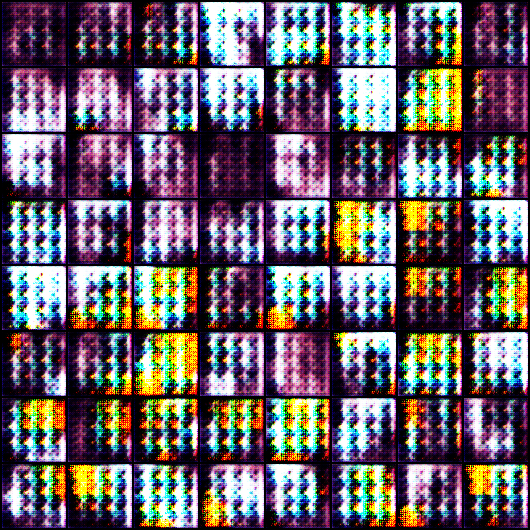

In [ ]:
Image('./results/result-image-0010.png')

At 25 epochs the fake pokemon have more defined shapes:

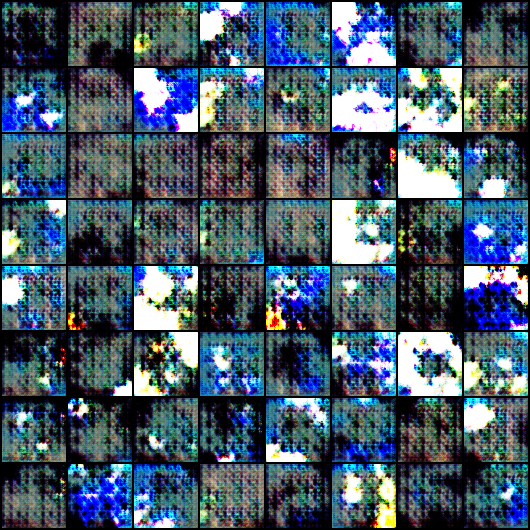

In [ ]:
Image('./results/result-image-0025.png')

And by 50 epochs, more distinct features start appearing:

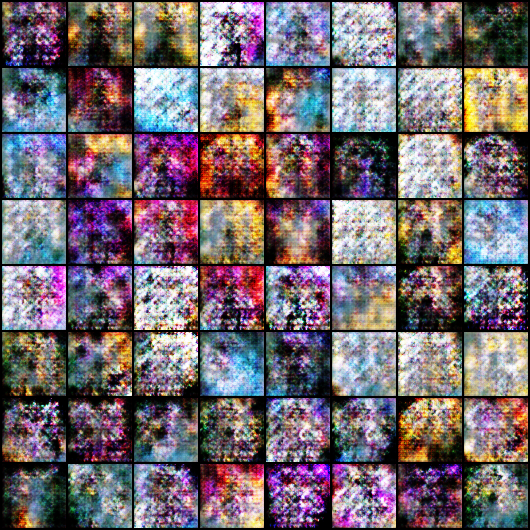

In [ ]:
Image('./results/result-image-0050.png')

# Performance Analysis

Here are some plots to help tune the generator/discriminator. This shows losses and scores over time.

In [ ]:
# Extract metrics
disc_losses, disc_scores, gen_losses, gen_scores = history

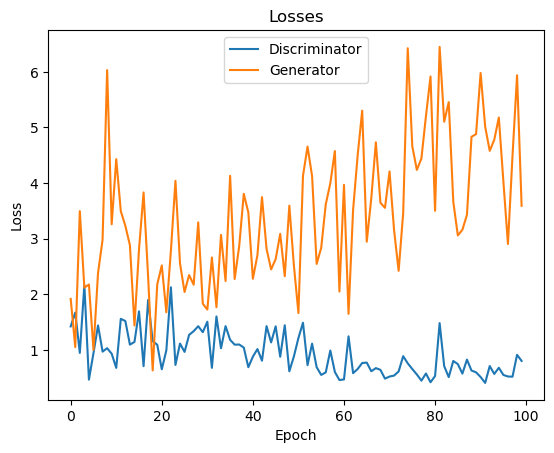

In [ ]:
# Plot generator and discriminator losses
plt.plot(disc_losses, '-')
plt.plot(gen_losses, '-')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Discriminator', 'Generator'])
plt.title('Losses');

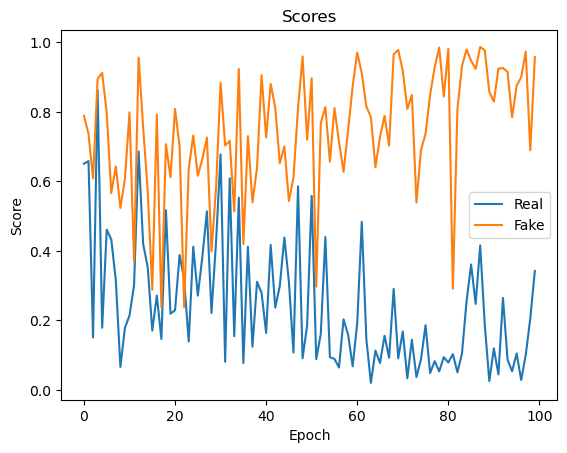

In [ ]:
# Plots scores vs. epochs
plt.plot(disc_scores, '-')
plt.plot(gen_scores, '-')
plt.xlabel('Epoch')
plt.ylabel('Score')
plt.legend(['Real', 'Fake'])
plt.title('Scores');

# Exporting Data
If the model works well, it definitely should be saved for later! Here I will export the weights for both the discriminator and generator, as well as send the notebook to Jovian.ml

In [ ]:
# Save generator and discriminator weights
torch.save(discriminator.state_dict(), 'discriminator-model.pth')
torch.save(generator.state_dict(), 'generator-model.pth')

In [ ]:
# Commit to Jovian
# !pip install jovian
import jovian
project_name = 'course-project-pokegan'
jovian.commit(project=project_name)

ModuleNotFoundError: No module named 'jovian'

# Acknowledgements

This wouldn't be possible without some good resources:

- Jovian.ml DCGAN example from PyTorch Zero to GANs Course: https://jovian.ml/aakashns/06b-anime-dcgan
- Tips and tricks about training GANs: https://medium.com/@utk.is.here/keep-calm-and-train-a-gan-pitfalls-and-tips-on-training-generative-adversarial-networks-edd529764aa9